In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-propensity-data/2020-Jan.csv


I. [Loading the Data:](#Loading-the-Data:)

II. [RFM Modeling:](#RFM-Modeling:)

III. [How RFM features helps in identifying the propensity to purchase of users?](#How-RFM-features-helps-in-identifying-the-propensity-to-purchase-of-users?)

## Loading the Data:

In [2]:
pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 5.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing the necessary Libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datetime import timedelta

import warnings 
warnings.filterwarnings('ignore')

In [4]:
cd '/kaggle/input/ecommerce-propensity-data/'

/kaggle/input/ecommerce-propensity-data


In [99]:
import time

start_time = time.time() # Noting the starting time

df1 = pd.read_csv('2020-Jan.csv')

pandas_time = time.time() - start_time  # counting the time took to read the dataset using pandas

print(f"Pandas: shape = {df1.shape}, time={pandas_time} Seconds")

Pandas: shape = (55967041, 9), time=100.95242714881897 Seconds


To do the RFM analysis, we need to create 3 features from the data:
* **Recency**   - Latest date - Last invoice date. (Number of days since the last purchase date)
* **Frequency** - count of invoice numbers. (Total number of transactions made by a unique customer)
* **Monetary**  - Sum of Total sales. (Total value of transacted sales by each customer)

Now, let's create a function which can be used to generate the RFM features.

In [100]:
# # Selecting 1% for pycaret testing purpose

# fraction_to_select= 0.1

# few_rows_df = df1

# selected_rows_df = few_rows_df.sample(frac= fraction_to_select, random_state=100)

# selected_rows_df.head()

In [101]:
# # data = df1

# data = selected_rows_df

# data.head()

In [102]:
data = df1

In [103]:
data.shape

(55967041, 9)

In [104]:
# splitting the category column
   
data[['main_category', 'subcategory']] = data['category_code'].str.split('.', n=1, expand= True)
print('Split successful')

Split successful


In [105]:
# Changing column names


column_mapping = {'event_time': 'Event_Time',
                  'event_type': 'Action',
                  'product_id': 'Product_id',
                  'category_id': 'Category_id',
                  'main_category': 'Main_Category',
                  'subcategory': 'Sub_Category',
                  'brand':'Brand',
                  'price': 'Total_Price',
                  'user_id': 'User_id',
                  'user_session': 'Session_id'}

In [106]:
# Renaming the columns
 
data = data.rename(columns = column_mapping )


In [107]:
# reordering the columns
 
data = data[['User_id','Session_id', 'Event_Time', 'Main_Category','Sub_Category','Brand','Action', 'Total_Price']]

In [108]:
# Changing the event_time type to datetime format
 
data['Event_Time'] = pd.to_datetime(data['Event_Time'])

In [109]:
def RFM_Features(df, customerID, invoiceDate, transID, sales ):
 
    latest_date = df[invoiceDate].max()+timedelta(1)
    
    # RFM features creation
    RFMScores = df.groupby(customerID).agg({invoiceDate: lambda x: (latest_date - x.max()).days, 
                                           transID: lambda x: len(x),
                                           sales: lambda x: sum(x)})
    
    # Converting invoice Dte to int since this contains number of day
    RFMScores[invoiceDate] = RFMScores[invoiceDate].astype(int)
    
    # Renaming the columns into Recency, Frequency and Monetary
    RFMScores.rename(columns = {invoiceDate :'Recency',
                               transID: 'Frequency',
                               sales: 'Monetary'}, inplace= True)
    
    
    return RFMScores.reset_index()
    
    

In [110]:
RFM = RFM_Features(df=data[data['Action']=='purchase'], customerID = 'User_id', invoiceDate= 'Event_Time', transID= 'Session_id', sales = 'Total_Price' )

print(RFM.shape)

RFM.head()

(359105, 4)


User_id  Recency  Frequency  Monetary
0  101875240       16          1    184.52
1  107620212        2          1    244.28
2  191555348       27          1    196.92
3  192078182       15          1    308.86
4  210849689       28          2     17.75

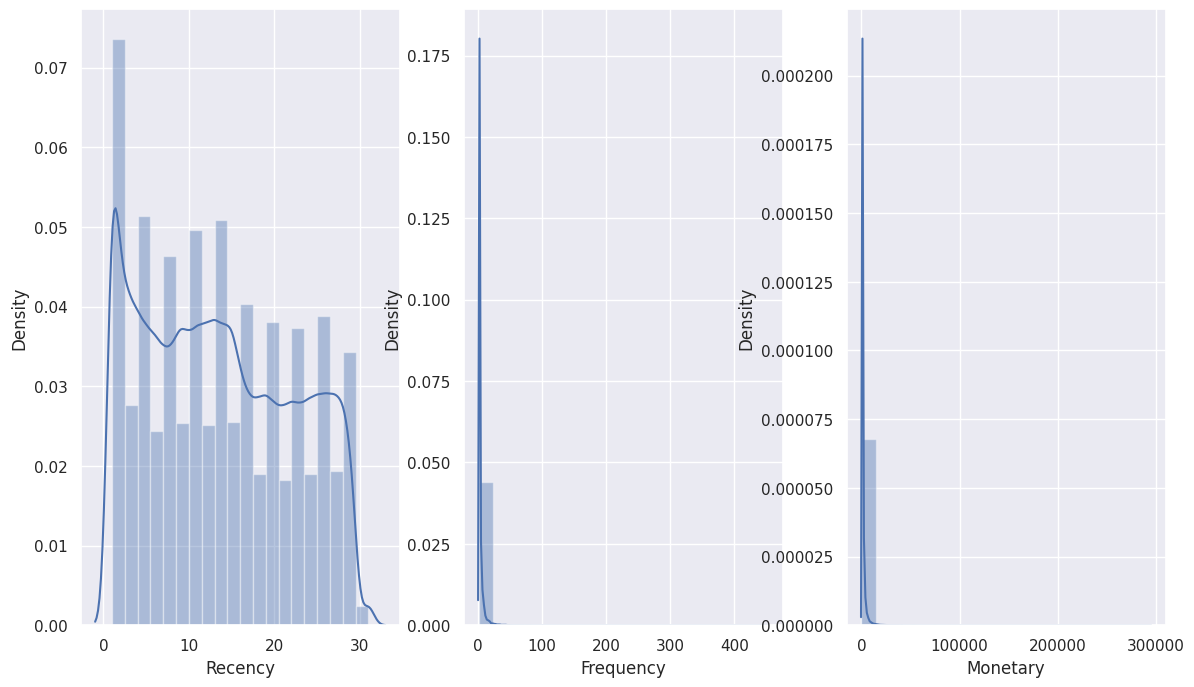

In [111]:
# Distribution of RFM features

# display(RFM.drop('User_id', axis=1))

fig, ax = plt.subplots(1,3, figsize=(14,8))
sns.distplot(RFM.Recency, bins=20, ax=ax[0])
sns.distplot(RFM.Frequency, bins=20, ax=ax[1])
sns.distplot(RFM.Monetary, bins=20, ax=ax[2])
plt.show()

In [112]:
Quantiles= RFM[['Recency','Frequency', 'Monetary']].quantile([0.25, 0.50, 0.75])

Quantiles =  Quantiles.to_dict()

Quantiles

{'Recency': {0.25: 6.0, 0.5: 13.0, 0.75: 21.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'Monetary': {0.25: 122.78, 0.5: 257.38, 0.75: 714.47}}

In [113]:
# Creating RFM ranks

def RFMRanking(x, variable, quantile_dict):
    if variable=='Recency':
        
        if x <= quantile_dict[variable][0.25]:
            return 4
        elif (x > quantile_dict[variable][0.25]) & (x <= quantile_dict[variable][0.5]):
            return 3
        elif (x > quantile_dict[variable][0.5]) & (x <= quantile_dict[variable][0.75]):
            return 2
        else:
            return 1
        
    if variable in ('Frequency', 'Monetary'):
        
        if x <= quantile_dict[variable][0.25]:
            return 1
        elif (x > quantile_dict[variable][0.25]) & (x <= quantile_dict[variable][0.5]):
            return 2
        elif (x > quantile_dict[variable][0.5]) & (x <= quantile_dict[variable][0.75]):
            return 3
        else:
            return 4

In [114]:
RFM['R'] = RFM['Recency'].apply(lambda x: RFMRanking(x, variable='Recency', quantile_dict=Quantiles))
RFM['F'] = RFM['Frequency'].apply(lambda x: RFMRanking(x, variable='Frequency', quantile_dict=Quantiles))
RFM['M'] = RFM['Monetary'].apply(lambda x: RFMRanking(x, variable='Monetary', quantile_dict=Quantiles))

In [115]:
print(RFM.shape)

(359105, 7)


In [116]:
RFM.head()

User_id  Recency  Frequency  Monetary  R  F  M
0  101875240       16          1    184.52  2  1  2
1  107620212        2          1    244.28  4  1  2
2  191555348       27          1    196.92  1  1  2
3  192078182       15          1    308.86  2  1  3
4  210849689       28          2     17.75  1  3  1

In [117]:
RFM['Group'] = RFM['R'].apply(str)+RFM['F'].apply(str)+RFM['M'].apply(str)

RFM.head()

User_id  Recency  Frequency  Monetary  R  F  M Group
0  101875240       16          1    184.52  2  1  2   212
1  107620212        2          1    244.28  4  1  2   412
2  191555348       27          1    196.92  1  1  2   112
3  192078182       15          1    308.86  2  1  3   213
4  210849689       28          2     17.75  1  3  1   131

In [118]:
RFM['Score'] = RFM[['R','F','M']].sum(axis=1)

RFM.head()

User_id  Recency  Frequency  Monetary  R  F  M Group  Score
0  101875240       16          1    184.52  2  1  2   212      5
1  107620212        2          1    244.28  4  1  2   412      7
2  191555348       27          1    196.92  1  1  2   112      4
3  192078182       15          1    308.86  2  1  3   213      6
4  210849689       28          2     17.75  1  3  1   131      5

In [119]:
# Loyalty levels

loyalty = ['Bronze', 'Silver', 'Gold', "Platinum"]

RFM['Loyalty_Level'] = pd.qcut(RFM['Score'], q=4, labels=loyalty)

RFM.head()

User_id  Recency  Frequency  Monetary  R  F  M Group  Score Loyalty_Level
0  101875240       16          1    184.52  2  1  2   212      5        Bronze
1  107620212        2          1    244.28  4  1  2   412      7        Silver
2  191555348       27          1    196.92  1  1  2   112      4        Bronze
3  192078182       15          1    308.86  2  1  3   213      6        Silver
4  210849689       28          2     17.75  1  3  1   131      5        Bronze

In [120]:
# Checking the loyalty frequency

RFM.Loyalty_Level.value_counts()

Loyalty_Level
Bronze      114723
Silver      103992
Platinum     74012
Gold         66378
Name: count, dtype: int64

In [121]:
RFM.shape

(359105, 10)

# Additional Feature engineering steps

In [122]:
RFM.head()

User_id  Recency  Frequency  Monetary  R  F  M Group  Score Loyalty_Level
0  101875240       16          1    184.52  2  1  2   212      5        Bronze
1  107620212        2          1    244.28  4  1  2   412      7        Silver
2  191555348       27          1    196.92  1  1  2   112      4        Bronze
3  192078182       15          1    308.86  2  1  3   213      6        Silver
4  210849689       28          2     17.75  1  3  1   131      5        Bronze

In [123]:
data.head()

User_id                            Session_id                Event_Time  \
0  519698804  69b5d72f-fd6e-4fed-aa23-1286b2ca89a0 2020-01-01 00:00:00+00:00   
1  527767423  7f596032-ccbf-4643-9bad-e36a209512b4 2020-01-01 00:00:01+00:00   
2  519046195  d1e2f343-84bb-49bd-b13d-ca0f1ed9910e 2020-01-01 00:00:01+00:00   
3  518269232  0444841c-38ef-410c-b11f-7b35ea4e5991 2020-01-01 00:00:01+00:00   
4  587748686  31b7d4cf-dfac-4895-9927-90fa3254f860 2020-01-01 00:00:02+00:00   

  Main_Category    Sub_Category    Brand Action  Total_Price  
0  construction     tools.light  samsung   view      1130.02  
1  construction     tools.light    meizu   view       205.67  
2       apparel           shirt   turtle   view       136.43  
3       apparel           shoes   xiaomi   view        29.95  
4       apparel  shoes.step_ins    intel   view       167.20

In [124]:
print(len(data.Action.value_counts()))


3


In [125]:
# Creating date level feature
data['Date'] = data['Event_Time'].dt.date

data['DayofWeek'] = data['Event_Time'].dt.dayofweek

data.head()

User_id                            Session_id                Event_Time  \
0  519698804  69b5d72f-fd6e-4fed-aa23-1286b2ca89a0 2020-01-01 00:00:00+00:00   
1  527767423  7f596032-ccbf-4643-9bad-e36a209512b4 2020-01-01 00:00:01+00:00   
2  519046195  d1e2f343-84bb-49bd-b13d-ca0f1ed9910e 2020-01-01 00:00:01+00:00   
3  518269232  0444841c-38ef-410c-b11f-7b35ea4e5991 2020-01-01 00:00:01+00:00   
4  587748686  31b7d4cf-dfac-4895-9927-90fa3254f860 2020-01-01 00:00:02+00:00   

  Main_Category    Sub_Category    Brand Action  Total_Price        Date  \
0  construction     tools.light  samsung   view      1130.02  2020-01-01   
1  construction     tools.light    meizu   view       205.67  2020-01-01   
2       apparel           shirt   turtle   view       136.43  2020-01-01   
3       apparel           shoes   xiaomi   view        29.95  2020-01-01   
4       apparel  shoes.step_ins    intel   view       167.20  2020-01-01   

   DayofWeek  
0          2  
1          2  
2          2  
3          2  
4          2

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55967041 entries, 0 to 55967040
Data columns (total 10 columns):
 #   Column         Dtype              
---  ------         -----              
 0   User_id        int64              
 1   Session_id     object             
 2   Event_Time     datetime64[ns, UTC]
 3   Main_Category  object             
 4   Sub_Category   object             
 5   Brand          object             
 6   Action         object             
 7   Total_Price    float64            
 8   Date           object             
 9   DayofWeek      int32              
dtypes: datetime64[ns, UTC](1), float64(1), int32(1), int64(1), object(6)
memory usage: 4.0+ GB


In [127]:
# Creating number of days active feature

temp_days_active = data.groupby('User_id').agg({'Event_Time':'nunique'}).reset_index()

temp_days_active.rename(columns={'Event_Time': 'no_of_days_active'}, inplace=True)

print(temp_days_active.shape)

temp_days_active.head()

(4385985, 2)


User_id  no_of_days_active
0  22165363                  2
1  29830839                  1
2  31198833                  1
3  32978429                  8
4  34526405                  1

In [128]:
# Average Time between purchase
temp = data.copy()


In [129]:
def purch_time_diff(x): 
    if len(x) == 2:
        return (x[1]-x[0]).days

    if len(x) == 3:
        diff_12 = (x[1]-x[0]).days
        diff_23 = (x[2]-x[1]).days
        return (diff_12+diff_23)/2

In [130]:
temp_user_purchase_date = (temp[temp['Action']=='purchase'].sort_values(by='Date')
                           .groupby('User_id').agg({'Date': lambda x: list(x)}).reset_index())
temp_user_purchase_date['purchase1'] = temp_user_purchase_date['Date'].apply(lambda x: x[0])
temp_user_purchase_date['purchase2'] = temp_user_purchase_date['Date'].apply(lambda x: x[1] if len(x)>1 else 0)
temp_user_purchase_date['purchase3'] = temp_user_purchase_date['Date'].apply(lambda x: x[2] if len(x)>2 else 0)
temp_user_purchase_date['avg_time_between_purchase'] = temp_user_purchase_date['Date'].apply(purch_time_diff)

print(temp_user_purchase_date.shape)
temp_user_purchase_date.head(20)

(359105, 6)


User_id                                               Date   purchase1  \
0   101875240                                       [2020-01-16]  2020-01-16   
1   107620212                                       [2020-01-30]  2020-01-30   
2   191555348                                       [2020-01-05]  2020-01-05   
3   192078182                                       [2020-01-17]  2020-01-17   
4   210849689                           [2020-01-04, 2020-01-04]  2020-01-04   
5   217628234                                       [2020-01-29]  2020-01-29   
6   221480173                                       [2020-01-20]  2020-01-20   
7   237470903                           [2020-01-27, 2020-01-30]  2020-01-27   
8   252875879                                       [2020-01-12]  2020-01-12   
9   256444651                                       [2020-01-29]  2020-01-29   
10  259560538                                       [2020-01-09]  2020-01-09   
11  265684599                                       [2020-01-19]  2020-01-19   
12  268788251                                       [2020-01-28]  2020-01-28   
13  289857272                           [2020-01-22, 2020-01-22]  2020-01-22   
14  297633028  [2020-01-30, 2020-01-31, 2020-01-31, 2020-01-3...  2020-01-30   
15  307478059                                       [2020-01-30]  2020-01-30   
16  309352812                                       [2020-01-06]  2020-01-06   
17  319912063                                       [2020-01-07]  2020-01-07   
18  334354735                                       [2020-01-23]  2020-01-23   
19  339068823                                       [2020-01-20]  2020-01-20   

     purchase2   purchase3  avg_time_between_purchase  
0            0           0                        NaN  
1            0           0                        NaN  
2            0           0                        NaN  
3            0           0                        NaN  
4   2020-01-04           0                        0.0  
5            0           0                        NaN  
6            0           0                        NaN  
7   2020-01-30           0                        3.0  
8            0           0                        NaN  
9            0           0                        NaN  
10           0           0                        NaN  
11           0           0                        NaN  
12           0           0                        NaN  
13  2020-01-22           0                        0.0  
14  2020-01-31  2020-01-31                        NaN  
15           0           0                        NaN  
16           0           0                        NaN  
17           0           0                        NaN  
18           0           0                        NaN  
19           0           0                        NaN

In [131]:
temp_user_purchase_date.head(50)

User_id                                               Date   purchase1  \
0   101875240                                       [2020-01-16]  2020-01-16   
1   107620212                                       [2020-01-30]  2020-01-30   
2   191555348                                       [2020-01-05]  2020-01-05   
3   192078182                                       [2020-01-17]  2020-01-17   
4   210849689                           [2020-01-04, 2020-01-04]  2020-01-04   
5   217628234                                       [2020-01-29]  2020-01-29   
6   221480173                                       [2020-01-20]  2020-01-20   
7   237470903                           [2020-01-27, 2020-01-30]  2020-01-27   
8   252875879                                       [2020-01-12]  2020-01-12   
9   256444651                                       [2020-01-29]  2020-01-29   
10  259560538                                       [2020-01-09]  2020-01-09   
11  265684599                                       [2020-01-19]  2020-01-19   
12  268788251                                       [2020-01-28]  2020-01-28   
13  289857272                           [2020-01-22, 2020-01-22]  2020-01-22   
14  297633028  [2020-01-30, 2020-01-31, 2020-01-31, 2020-01-3...  2020-01-30   
15  307478059                                       [2020-01-30]  2020-01-30   
16  309352812                                       [2020-01-06]  2020-01-06   
17  319912063                                       [2020-01-07]  2020-01-07   
18  334354735                                       [2020-01-23]  2020-01-23   
19  339068823                                       [2020-01-20]  2020-01-20   
20  341252410                                       [2020-01-08]  2020-01-08   
21  346447936                                       [2020-01-30]  2020-01-30   
22  353711846                                       [2020-01-21]  2020-01-21   
23  354303483                                       [2020-01-28]  2020-01-28   
24  369768023   [2020-01-08, 2020-01-08, 2020-01-08, 2020-01-23]  2020-01-08   
25  378316704                                       [2020-01-22]  2020-01-22   
26  378879891                           [2020-01-12, 2020-01-18]  2020-01-12   
27  379217369                                       [2020-01-17]  2020-01-17   
28  380643194                                       [2020-01-18]  2020-01-18   
29  381172544                                       [2020-01-17]  2020-01-17   
30  381813330                                       [2020-01-07]  2020-01-07   
31  382633881                                       [2020-01-01]  2020-01-01   
32  383209756                                       [2020-01-20]  2020-01-20   
33  383787337                                       [2020-01-12]  2020-01-12   
34  384132955                                       [2020-01-09]  2020-01-09   
35  385839999                                       [2020-01-20]  2020-01-20   
36  386299319                                       [2020-01-12]  2020-01-12   
37  389204066                                       [2020-01-31]  2020-01-31   
38  389490640                                       [2020-01-03]  2020-01-03   
39  390878829                                       [2020-01-11]  2020-01-11   
40  393237889                                       [2020-01-28]  2020-01-28   
41  396308331                                       [2020-01-12]  2020-01-12   
42  397288915                                       [2020-01-07]  2020-01-07   
43  404390052                                       [2020-01-30]  2020-01-30   
44  404851685                           [2020-01-07, 2020-01-08]  2020-01-07   
45  407521084                                       [2020-01-19]  2020-01-19   
46  407951852                                       [2020-01-22]  2020-01-22   
47  410989106                                       [2020-01-06]  2020-01-06   
48  413102067                                       [2020-01-23]  2020-01-23   
49  41

In [132]:
import gc 

gc.collect()

0

In [133]:
# Cart to purchase ratio

del temp
temp = data.copy()



In [134]:
def purchase_ratios(action_col = 'cart', id_col= 'User_id', col_name='no_of_carts'):
    
    test1 = (temp[temp['Action']==action_col].groupby(id_col).agg({'Session_id': 'count'}).reset_index())
    
    test1.rename(columns={'Session_id': col_name}, inplace =True)
    print(test1.shape)
    
    test2 = temp[temp['Action']=='purchase'].groupby(id_col).agg({'Session_id':'count'}).reset_index()
    test2.rename(columns = {'Session_id':'no_of_purch'}, inplace =True)
    print(test2.shape)
    
    test_ratio = pd.merge(test1, test2, on=id_col, how='left')
    test_ratio = test_ratio.fillna(0)
    test_ratio[col_name + '_to_purchase_ratio'] = (test_ratio['no_of_purch']/test_ratio[col_name])
    
    print(test_ratio.shape)
    return test_ratio

In [135]:
# Main category level - cart to purchase ratio

temp_cart_purch_ratio_main_category = purchase_ratios(action_col='cart', id_col='Main_Category', col_name= 'category_no_of_carts' )

display(temp_cart_purch_ratio_main_category.head())

temp_cart_purch_ratio_main_category.describe()

(13, 2)
(13, 2)
(13, 4)


Main_Category  category_no_of_carts  no_of_purch  \
0   accessories                 21641         5528   
1       apparel                248138        65842   
2    appliances                372522       114786   
3          auto                 16956         5089   
4     computers                 77322        22552   

   category_no_of_carts_to_purchase_ratio  
0                                0.255441  
1                                0.265344  
2                                0.308132  
3                                0.300130  
4                                0.291663

category_no_of_carts    no_of_purch  \
count          1.300000e+01      13.000000   
mean           1.876808e+05   60432.615385   
std            3.172350e+05  113443.990613   
min            9.810000e+02     233.000000   
25%            1.695600e+04    5089.000000   
50%            7.732200e+04   22552.000000   
75%            2.045690e+05   64015.000000   
max            1.172013e+06  420131.000000   

       category_no_of_carts_to_purchase_ratio  
count                               13.000000  
mean                                 0.275139  
std                                  0.042176  
min                                  0.194491  
25%                                  0.255441  
50%                                  0.277264  
75%                                  0.300130  
max                                  0.358470

In [136]:
# Subctegory level- cart to purchase ratio

temp_cart_purch_ratio_subcategory = (purchase_ratios(action_col = 'cart',
                                                    id_col='Sub_Category',
                                                    col_name= 'subcategory_no_of_carts'))

display(temp_cart_purch_ratio_subcategory.head())
temp_cart_purch_ratio_subcategory.describe()

(135, 2)
(135, 2)
(135, 4)


Sub_Category  subcategory_no_of_carts  no_of_purch  \
0        accessories.alarm                     3331          884   
1  accessories.anti_freeze                      476          129   
2   accessories.compressor                     7607         2666   
3        accessories.light                        7            2   
4   accessories.parktronic                      247           60   

   subcategory_no_of_carts_to_purchase_ratio  
0                                   0.265386  
1                                   0.271008  
2                                   0.350467  
3                                   0.285714  
4                                   0.242915

subcategory_no_of_carts    no_of_purch  \
count             1.350000e+02     135.000000   
mean              1.807297e+04    5819.437037   
std               9.774576e+04   35183.875615   
min               7.000000e+00       2.000000   
25%               9.775000e+02     224.500000   
50%               3.820000e+03     930.000000   
75%               1.107350e+04    2846.500000   
max               1.124028e+06  406058.000000   

       subcategory_no_of_carts_to_purchase_ratio  
count                                 135.000000  
mean                                    0.257654  
std                                     0.057475  
min                                     0.080882  
25%                                     0.230931  
50%                                     0.261807  
75%                                     0.288568  
max                                     0.466667

In [137]:
gc.collect()

0

#### Product View to Purchase ratio (Category/SubCategory):

In [138]:
del temp

In [139]:
temp = data.copy()

In [140]:
# Category level - product view to purchase ratio

temp_product_view_purch_ratio_main_category = (purchase_ratios(action_col='view',
                                                              id_col='Main_Category',
                                                              col_name='category_no_of_product_view'))

print(temp_product_view_purch_ratio_main_category.shape)
display(temp_product_view_purch_ratio_main_category.head())
temp_product_view_purch_ratio_main_category.describe()

(13, 2)
(13, 2)
(13, 4)
(13, 4)


Main_Category  category_no_of_product_view  no_of_purch  \
0   accessories                       775705         5528   
1       apparel                      7060719        65842   
2    appliances                      8813119       114786   
3          auto                       459209         5089   
4     computers                      2614260        22552   

   category_no_of_product_view_to_purchase_ratio  
0                                       0.007126  
1                                       0.009325  
2                                       0.013024  
3                                       0.011082  
4                                       0.008627

category_no_of_product_view    no_of_purch  \
count                 1.300000e+01      13.000000   
mean                  3.668974e+06   60432.615385   
std                   4.456152e+06  113443.990613   
min                   3.117300e+04     233.000000   
25%                   4.592090e+05    5089.000000   
50%                   2.518802e+06   22552.000000   
75%                   5.705786e+06   64015.000000   
max                   1.509482e+07  420131.000000   

       category_no_of_product_view_to_purchase_ratio  
count                                      13.000000  
mean                                        0.011408  
std                                         0.005524  
min                                         0.007126  
25%                                         0.008627  
50%                                         0.009616  
75%                                         0.011219  
max                                         0.027833

In [141]:
# Subcategory level -product_view_purchase_ratio

temp_product_view_purch_ratio_sub_category = (purchase_ratios(action_col='view',
                                                              id_col='Sub_Category',
                                                              col_name='category_no_of_product_view'))

print(temp_product_view_purch_ratio_sub_category.shape)
display(temp_product_view_purch_ratio_sub_category.head())
temp_product_view_purch_ratio_sub_category.describe()

(135, 2)
(135, 2)
(135, 4)
(135, 4)


Sub_Category  category_no_of_product_view  no_of_purch  \
0        accessories.alarm                        63097          884   
1  accessories.anti_freeze                        15325          129   
2   accessories.compressor                       229661         2666   
3        accessories.light                          167            2   
4   accessories.parktronic                        12698           60   

   category_no_of_product_view_to_purchase_ratio  
0                                       0.014010  
1                                       0.008418  
2                                       0.011608  
3                                       0.011976  
4                                       0.004725

category_no_of_product_view    no_of_purch  \
count                 1.350000e+02     135.000000   
mean                  3.533086e+05    5819.437037   
std                   1.208012e+06   35183.875615   
min                   1.670000e+02       2.000000   
25%                   2.909850e+04     224.500000   
50%                   1.256410e+05     930.000000   
75%                   3.375090e+05    2846.500000   
max                   1.356083e+07  406058.000000   

       category_no_of_product_view_to_purchase_ratio  
count                                     135.000000  
mean                                        0.008751  
std                                         0.004128  
min                                         0.002441  
25%                                         0.005741  
50%                                         0.008213  
75%                                         0.010933  
max                                         0.029943

## How RFM features helps in identifying the propensity to purchase of users?

There are two broad ways in which the RFM features can be utilized:
* **Preferrential Treatments:** RFM features and loyalty tags will be available only for existing users. So, whenever old users shows interest in any product, based on their loyalty tags we can target them with personalized discounts etc.


* **High value path:** We can analyze the behaviour exhibited by the old users and create multiple behaviour paths that leads to increased purchase. This learning can then be used to nudge new users to follow such paths and hence increase the probability of purchase.

![image.png](attachment:image.png)

In [142]:
data_with_RFM = pd.merge(data, RFM, on = 'User_id', how='left')   
print(data_with_RFM.shape)   
data_with_RFM.head()   

(55967041, 19)


User_id                            Session_id                Event_Time  \
0  519698804  69b5d72f-fd6e-4fed-aa23-1286b2ca89a0 2020-01-01 00:00:00+00:00   
1  527767423  7f596032-ccbf-4643-9bad-e36a209512b4 2020-01-01 00:00:01+00:00   
2  519046195  d1e2f343-84bb-49bd-b13d-ca0f1ed9910e 2020-01-01 00:00:01+00:00   
3  518269232  0444841c-38ef-410c-b11f-7b35ea4e5991 2020-01-01 00:00:01+00:00   
4  587748686  31b7d4cf-dfac-4895-9927-90fa3254f860 2020-01-01 00:00:02+00:00   

  Main_Category    Sub_Category    Brand Action  Total_Price        Date  \
0  construction     tools.light  samsung   view      1130.02  2020-01-01   
1  construction     tools.light    meizu   view       205.67  2020-01-01   
2       apparel           shirt   turtle   view       136.43  2020-01-01   
3       apparel           shoes   xiaomi   view        29.95  2020-01-01   
4       apparel  shoes.step_ins    intel   view       167.20  2020-01-01   

   DayofWeek  Recency  Frequency  Monetary    R    F    M Group  Score  \
0          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   
1          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   
2          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   
3          2     28.0        6.0    619.49  1.0  4.0  3.0   143    8.0   
4          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   

  Loyalty_Level  
0           NaN  
1           NaN  
2           NaN  
3          Gold  
4           NaN

In [143]:
data_with_RFM.isnull().sum()   

User_id                 0
Session_id             19
Event_Time              0
Main_Category     5044890
Sub_Category      5044890
Brand             6540255
Action                  0
Total_Price             0
Date                    0
DayofWeek               0
Recency          40043068
Frequency        40043068
Monetary         40043068
R                40043068
F                40043068
M                40043068
Group            40043068
Score            40043068
Loyalty_Level    40043068
dtype: int64

In [144]:
# checking the percentage of null values

round(data_with_RFM.isnull().mean(), 2)   

User_id          0.00
Session_id       0.00
Event_Time       0.00
Main_Category    0.09
Sub_Category     0.09
Brand            0.12
Action           0.00
Total_Price      0.00
Date             0.00
DayofWeek        0.00
Recency          0.72
Frequency        0.72
Monetary         0.72
R                0.72
F                0.72
M                0.72
Group            0.72
Score            0.72
Loyalty_Level    0.72
dtype: float64

In [145]:
data_with_RFM.shape   

(55967041, 19)

In [146]:
behaviour = RFM.groupby('Loyalty_Level')[['Recency','Frequency', 'Monetary','Score']].mean()

behaviour

Recency  Frequency     Monetary      Score
Loyalty_Level                                              
Bronze         20.240579   1.017869   137.350731   4.263713
Silver         11.977518   1.191832   329.283277   6.438082
Gold           11.899138   2.163880   710.913273   8.463708
Platinum        6.773820   6.088999  2213.772826  10.921648

# Dataset Creation

In [147]:
data_with_RFM.head()

User_id                            Session_id                Event_Time  \
0  519698804  69b5d72f-fd6e-4fed-aa23-1286b2ca89a0 2020-01-01 00:00:00+00:00   
1  527767423  7f596032-ccbf-4643-9bad-e36a209512b4 2020-01-01 00:00:01+00:00   
2  519046195  d1e2f343-84bb-49bd-b13d-ca0f1ed9910e 2020-01-01 00:00:01+00:00   
3  518269232  0444841c-38ef-410c-b11f-7b35ea4e5991 2020-01-01 00:00:01+00:00   
4  587748686  31b7d4cf-dfac-4895-9927-90fa3254f860 2020-01-01 00:00:02+00:00   

  Main_Category    Sub_Category    Brand Action  Total_Price        Date  \
0  construction     tools.light  samsung   view      1130.02  2020-01-01   
1  construction     tools.light    meizu   view       205.67  2020-01-01   
2       apparel           shirt   turtle   view       136.43  2020-01-01   
3       apparel           shoes   xiaomi   view        29.95  2020-01-01   
4       apparel  shoes.step_ins    intel   view       167.20  2020-01-01   

   DayofWeek  Recency  Frequency  Monetary    R    F    M Group  Score  \
0          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   
1          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   
2          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   
3          2     28.0        6.0    619.49  1.0  4.0  3.0   143    8.0   
4          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   

  Loyalty_Level  
0           NaN  
1           NaN  
2           NaN  
3          Gold  
4           NaN

In [148]:
data_with_RFM.shape

(55967041, 19)

In [149]:
df = data_with_RFM

In [150]:
df['Action'].unique()

array(['view', 'cart', 'purchase'], dtype=object)

In [151]:
# # Target group of people are those who added items to the cart (Trigger point)


# df_base = (df[df['Action']=='cart']
#           .groupby('User_id').agg({'Main_Category':lambda x: pd.Series(x).mode(),
#                                 'Sub_Category':lambda x: pd.Series(x).mode()}).reset_index())


In [152]:
df_base = (df[df['Action']=='cart']
          .groupby('User_id').agg({'Main_Category':pd.Series.mode,'Sub_Category':pd.Series.mode}).reset_index())


In [153]:
print(df_base.shape)
df_base.head()

(740737, 3)


User_id Main_Category                 Sub_Category
0   94566147    appliances               kitchen.toster
1  100037567       apparel               shoes.step_ins
2  100140882    appliances  environment.air_conditioner
3  101875240  construction                  tools.light
4  107620212         sport                          ski

In [154]:
# Adding days_active

df_base = pd.merge(df_base, temp_days_active, on='User_id', how='left')
print(df_base.shape)
df_base.head(3)

(740737, 4)


User_id Main_Category                 Sub_Category  no_of_days_active
0   94566147    appliances               kitchen.toster                 30
1  100037567       apparel               shoes.step_ins                 83
2  100140882    appliances  environment.air_conditioner                 45

In [155]:
# Adding RFM features
temp_rfm_feats = df.groupby('User_id').agg({'R': 'max','F':'max','M':'max','Loyalty_Level':'max'}).reset_index()
df_base = pd.merge(df_base, temp_rfm_feats, on='User_id', how='left')
print(df_base.shape)
df_base.head(3)

(740737, 8)


User_id Main_Category                 Sub_Category  no_of_days_active  \
0   94566147    appliances               kitchen.toster                 30   
1  100037567       apparel               shoes.step_ins                 83   
2  100140882    appliances  environment.air_conditioner                 45   

    R   F   M Loyalty_Level  
0 NaN NaN NaN           NaN  
1 NaN NaN NaN           NaN  
2 NaN NaN NaN           NaN

In [156]:
# Adding average time between purchase
df_base = pd.merge(df_base, temp_user_purchase_date[['User_id','avg_time_between_purchase']], 
                   on='User_id', how='left')
print(df_base.shape)
df_base.head(3)

(740737, 9)


User_id Main_Category                 Sub_Category  no_of_days_active  \
0   94566147    appliances               kitchen.toster                 30   
1  100037567       apparel               shoes.step_ins                 83   
2  100140882    appliances  environment.air_conditioner                 45   

    R   F   M Loyalty_Level  avg_time_between_purchase  
0 NaN NaN NaN           NaN                        NaN  
1 NaN NaN NaN           NaN                        NaN  
2 NaN NaN NaN           NaN                        NaN

In [157]:
temp_cart_purch_ratio_main_category[['Main_Category','category_no_of_carts_to_purchase_ratio']]

Main_Category  category_no_of_carts_to_purchase_ratio
0    accessories                                0.255441
1        apparel                                0.265344
2     appliances                                0.308132
3           auto                                0.300130
4      computers                                0.291663
5   construction                                0.358470
6   country_yard                                0.224466
7    electronics                                0.312926
8      furniture                                0.270102
9           kids                                0.238052
10      medicine                                0.280326
11         sport                                0.277264
12    stationery                                0.194491

In [158]:
temp_cart_purch_ratio_subcategory[['Sub_Category','subcategory_no_of_carts_to_purchase_ratio']][:10]

Sub_Category  subcategory_no_of_carts_to_purchase_ratio
0          accessories.alarm                                   0.265386
1    accessories.anti_freeze                                   0.271008
2     accessories.compressor                                   0.350467
3          accessories.light                                   0.285714
4     accessories.parktronic                                   0.242915
5         accessories.player                                   0.299200
6          accessories.radar                                   0.252184
7  accessories.videoregister                                   0.219723
8          accessories.winch                                   0.254627
9             audio.acoustic                                   0.320795

In [159]:
df_base

User_id Main_Category                 Sub_Category  \
0        94566147    appliances               kitchen.toster   
1       100037567       apparel               shoes.step_ins   
2       100140882    appliances  environment.air_conditioner   
3       101875240  construction                  tools.light   
4       107620212         sport                          ski   
...           ...           ...                          ...   
740732  608818913            []                           []   
740733  608819024  construction                  tools.light   
740734  608819135  construction                  tools.light   
740735  608819836  construction                  tools.light   
740736  608821433  construction                  tools.light   

        no_of_days_active    R    F    M Loyalty_Level  \
0                      30  NaN  NaN  NaN           NaN   
1                      83  NaN  NaN  NaN           NaN   
2                      45  NaN  NaN  NaN           NaN   
3                      19  2.0  1.0  2.0        Bronze   
4                      27  4.0  1.0  2.0        Silver   
...                   ...  ...  ...  ...           ...   
740732                  5  4.0  1.0  1.0        Silver   
740733                 21  NaN  NaN  NaN           NaN   
740734                  4  NaN  NaN  NaN           NaN   
740735                 26  4.0  4.0  2.0      Platinum   
740736                  4  4.0  1.0  2.0        Silver   

        avg_time_between_purchase  
0                             NaN  
1                             NaN  
2                             NaN  
3                             NaN  
4                             NaN  
...                           ...  
740732                        NaN  
740733                        NaN  
740734                        NaN  
740735                        0.0  
740736                        NaN  

[740737 rows x 9 columns]

In [160]:

# # Assuming df_base has a column named 'Main_Category' containing lists
# df_base['Main_Category'] = df_base['Main_Category'].apply(lambda x: x[0] if isinstance(x, list) else x)

# # Now, you can check the unique values
# unique_main_categories = df_base['Main_Category'].unique()
# print(unique_main_categories)

In [161]:
# Assuming df_base has a column named 'Main_Category' containing arrays
df_base_exploded = df_base.explode('Main_Category')

# Now, you can check the unique values
unique_main_categories = df_base_exploded['Main_Category'].unique()
print(unique_main_categories)

['appliances' 'apparel' 'construction' 'sport' 'computers' 'accessories'
 nan 'country_yard' 'furniture' 'electronics' 'auto' 'kids' 'medicine'
 'stationery']


In [162]:
df.head()

User_id                            Session_id                Event_Time  \
0  519698804  69b5d72f-fd6e-4fed-aa23-1286b2ca89a0 2020-01-01 00:00:00+00:00   
1  527767423  7f596032-ccbf-4643-9bad-e36a209512b4 2020-01-01 00:00:01+00:00   
2  519046195  d1e2f343-84bb-49bd-b13d-ca0f1ed9910e 2020-01-01 00:00:01+00:00   
3  518269232  0444841c-38ef-410c-b11f-7b35ea4e5991 2020-01-01 00:00:01+00:00   
4  587748686  31b7d4cf-dfac-4895-9927-90fa3254f860 2020-01-01 00:00:02+00:00   

  Main_Category    Sub_Category    Brand Action  Total_Price        Date  \
0  construction     tools.light  samsung   view      1130.02  2020-01-01   
1  construction     tools.light    meizu   view       205.67  2020-01-01   
2       apparel           shirt   turtle   view       136.43  2020-01-01   
3       apparel           shoes   xiaomi   view        29.95  2020-01-01   
4       apparel  shoes.step_ins    intel   view       167.20  2020-01-01   

   DayofWeek  Recency  Frequency  Monetary    R    F    M Group  Score  \
0          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   
1          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   
2          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   
3          2     28.0        6.0    619.49  1.0  4.0  3.0   143    8.0   
4          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   

  Loyalty_Level  
0           NaN  
1           NaN  
2           NaN  
3          Gold  
4           NaN

In [163]:
df.Loyalty_Level.unique()

[NaN, 'Gold', 'Silver', 'Platinum', 'Bronze']
Categories (4, object): ['Bronze' < 'Silver' < 'Gold' < 'Platinum']

In [164]:
df.Sub_Category.unique()

array(['tools.light', 'shirt', 'shoes', 'shoes.step_ins', 'costume',
       'personal.massager', 'kitchen.kettle', 'bicycle',
       'kitchen.blender', nan, 'clocks', 'kitchen.washer',
       'personal.hair_cutter', 'living_room.chair', 'toys',
       'bedroom.blanket', 'smartphone', 'shoes.ballet_shoes',
       'shoes.slipons', 'components.memory', 'audio.acoustic',
       'components.faucet', 'scarf', 'kitchen.coffee_grinder',
       'kitchen.refrigerators', 'audio.headphone', 'shoes.sandals',
       'audio.subwoofer', 'living_room.sofa', 'diving', 'kitchen.toster',
       'swing', 'desktop', 'kitchen.meat_grinder', 'bedroom.bed',
       'underwear', 'video.tv', 'tools.saw', 'telephone', 'kitchen.grill',
       'jumper', 'shoes.keds', 'notebook', 'dolls', 'living_room.cabinet',
       'ebooks', 'jeans', 'bag', 'universal.light', 'shoes.moccasins',
       'peripherals.printer', 'ski', 'accessories.compressor',
       'kitchen.oven', 'kitchen.juicer', 'components.cooler',
       'ironi

In [165]:

# # Merge on exploded main category
# df_base = pd.merge(df_base, temp_main_category_exp[['Main_Category','category_no_of_carts_to_purchase_ratio']], 
#                    left_on='Main_Category', right_on='Main_Category', how='left')


# # Merge on exploded subcategory
# df_base = pd.merge(df_base, temp_subcategory_exp[['Sub_Category','subcategory_no_of_carts_to_purchase_ratio']], 
#                    left_on='Sub_Category', right_on='Sub_Category', how='left')


In [166]:
df_base.isna().sum()

User_id                           0
Main_Category                     0
Sub_Category                      0
no_of_days_active                 0
R                            385035
F                            385035
M                            385035
Loyalty_Level                385035
avg_time_between_purchase    647761
dtype: int64

In [167]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740737 entries, 0 to 740736
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   User_id                    740737 non-null  int64   
 1   Main_Category              740737 non-null  object  
 2   Sub_Category               740737 non-null  object  
 3   no_of_days_active          740737 non-null  int64   
 4   R                          355702 non-null  float64 
 5   F                          355702 non-null  float64 
 6   M                          355702 non-null  float64 
 7   Loyalty_Level              355702 non-null  category
 8   avg_time_between_purchase  92976 non-null   float64 
dtypes: category(1), float64(4), int64(2), object(2)
memory usage: 45.9+ MB


In [168]:
# # Identify categorical columns
# categorical_columns = df_base.select_dtypes(include='category').columns

# # Fill NaN values with a valid category
# df_base[categorical_columns] = df_base[categorical_columns].fillna('Unknown')

# # Convert 'avg_time_between_purchase' column to numeric (if it's not already)
# df_base['avg_time_between_purchase'] = pd.to_numeric(df_base['avg_time_between_purchase'], errors='coerce')

# # Null value imputation
# df_base['avg_time_between_purchase'] = df_base['avg_time_between_purchase'].fillna(-1)
# df_base = df_base.fillna(0)

# # Convert back to original categories
# df_base[categorical_columns] = df_base[categorical_columns].astype('category')

# # Check for null values
# df_base.isna().sum()


In [169]:
df_base = df_base.dropna()

# Check for null values after removing
df_base.isna().sum()

User_id                      0
Main_Category                0
Sub_Category                 0
no_of_days_active            0
R                            0
F                            0
M                            0
Loyalty_Level                0
avg_time_between_purchase    0
dtype: int64

# Model Building

In [170]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [171]:
df_model = df_base.copy()
print(df_model.shape)
df_model.head()

(92976, 9)


User_id Main_Category         Sub_Category  no_of_days_active    R  \
19   210849689     furniture  living_room.cabinet                 53  1.0   
29   237470903  construction          tools.light                 49  4.0   
70   289857272  construction    components.faucet                 34  3.0   
163  378879891         sport              bicycle                 69  2.0   
221  404851685          auto   accessories.player                 12  1.0   

       F    M Loyalty_Level  avg_time_between_purchase  
19   3.0  1.0        Bronze                        0.0  
29   3.0  4.0      Platinum                        3.0  
70   3.0  3.0          Gold                        0.0  
163  3.0  2.0        Silver                        6.0  
221  3.0  3.0        Silver                        1.0

In [172]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92976 entries, 19 to 740735
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   User_id                    92976 non-null  int64   
 1   Main_Category              92976 non-null  object  
 2   Sub_Category               92976 non-null  object  
 3   no_of_days_active          92976 non-null  int64   
 4   R                          92976 non-null  float64 
 5   F                          92976 non-null  float64 
 6   M                          92976 non-null  float64 
 7   Loyalty_Level              92976 non-null  category
 8   avg_time_between_purchase  92976 non-null  float64 
dtypes: category(1), float64(4), int64(2), object(2)
memory usage: 6.5+ MB


In [173]:
df.head()

User_id                            Session_id                Event_Time  \
0  519698804  69b5d72f-fd6e-4fed-aa23-1286b2ca89a0 2020-01-01 00:00:00+00:00   
1  527767423  7f596032-ccbf-4643-9bad-e36a209512b4 2020-01-01 00:00:01+00:00   
2  519046195  d1e2f343-84bb-49bd-b13d-ca0f1ed9910e 2020-01-01 00:00:01+00:00   
3  518269232  0444841c-38ef-410c-b11f-7b35ea4e5991 2020-01-01 00:00:01+00:00   
4  587748686  31b7d4cf-dfac-4895-9927-90fa3254f860 2020-01-01 00:00:02+00:00   

  Main_Category    Sub_Category    Brand Action  Total_Price        Date  \
0  construction     tools.light  samsung   view      1130.02  2020-01-01   
1  construction     tools.light    meizu   view       205.67  2020-01-01   
2       apparel           shirt   turtle   view       136.43  2020-01-01   
3       apparel           shoes   xiaomi   view        29.95  2020-01-01   
4       apparel  shoes.step_ins    intel   view       167.20  2020-01-01   

   DayofWeek  Recency  Frequency  Monetary    R    F    M Group  Score  \
0          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   
1          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   
2          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   
3          2     28.0        6.0    619.49  1.0  4.0  3.0   143    8.0   
4          2      NaN        NaN       NaN  NaN  NaN  NaN   NaN    NaN   

  Loyalty_Level  
0           NaN  
1           NaN  
2           NaN  
3          Gold  
4           NaN

In [174]:
# Let us add the Target column

temp = (df.sort_values(by='Event_Time')
        [(df.Event_Time ==df.User_id.map(df[df['Action']=='purchase'].groupby('User_id').Event_Time.max()))]
       )

print(temp.shape)
temp.head()

(368232, 19)


User_id                            Session_id  \
146033  595461654  1a88068f-d832-467d-a867-b9dfdd3da7a3   
146115  520404769  9949d083-6c64-4188-9ce5-f90e77b4645a   
146587  587025007  807b3ca1-5670-4e3d-8f24-5dfed4ee46f1   
146995  594453674  cbea3fc9-b9f6-43a5-8749-a28f031e8c6b   
147627  566691545  f30ca250-6aed-4fd3-b2fb-c2ac5845712b   

                      Event_Time Main_Category        Sub_Category     Brand  \
146033 2020-01-01 05:53:53+00:00  construction         tools.light     apple   
146115 2020-01-01 05:53:57+00:00    appliances  kitchen.dishwasher     bosch   
146587 2020-01-01 05:54:23+00:00   electronics          smartphone     apple   
146995 2020-01-01 05:54:45+00:00    appliances       kitchen.mixer  dauscher   
147627 2020-01-01 05:55:17+00:00    appliances   personal.massager        lg   

          Action  Total_Price        Date  DayofWeek  Recency  Frequency  \
146033  purchase      1275.16  2020-01-01          2     31.0        1.0   
146115  purchase       679.53  2020-01-01          2     31.0        1.0   
146587  purchase       348.79  2020-01-01          2     31.0        1.0   
146995  purchase        15.42  2020-01-01          2     31.0        1.0   
147627  purchase       434.76  2020-01-01          2     31.0        1.0   

        Monetary    R    F    M Group  Score Loyalty_Level  
146033   1275.16  1.0  1.0  4.0   114    6.0        Silver  
146115    679.53  1.0  1.0  3.0   113    5.0        Bronze  
146587    348.79  1.0  1.0  3.0   113    5.0        Bronze  
146995     15.42  1.0  1.0  1.0   111    3.0        Bronze  
147627    434.76  1.0  1.0  3.0   113    5.0        Bronze

In [175]:
purchase_users = temp[temp['Action']=='purchase'].groupby('User_id')['Action'].count().reset_index()
display(purchase_users.head())

User_id  Action
0  101875240       1
1  107620212       1
2  191555348       1
3  192078182       1
4  210849689       1

In [176]:
purchase_users.Action.value_counts()

Action
1    359013
2        84
3         6
4         1
5         1
Name: count, dtype: int64

In [177]:
df_base = pd.merge(df_base, purchase_users, on='User_id', how='left')
df_base['Action'] =df_base['Action'].fillna(0)
df_base.rename(columns={'Action':'Target'}, inplace=True)
print(df_base.shape)
print(df_base.Target.value_counts())
df_base.head()

(92976, 10)
Target
1    92943
2       32
3        1
Name: count, dtype: int64


User_id Main_Category         Sub_Category  no_of_days_active    R    F  \
0  210849689     furniture  living_room.cabinet                 53  1.0  3.0   
1  237470903  construction          tools.light                 49  4.0  3.0   
2  289857272  construction    components.faucet                 34  3.0  3.0   
3  378879891         sport              bicycle                 69  2.0  3.0   
4  404851685          auto   accessories.player                 12  1.0  3.0   

     M Loyalty_Level  avg_time_between_purchase  Target  
0  1.0        Bronze                        0.0       1  
1  4.0      Platinum                        3.0       1  
2  3.0          Gold                        0.0       1  
3  2.0        Silver                        6.0       1  
4  3.0        Silver                        1.0       1

In [178]:
# binary classification with classes 1 and 2, 
# where class 1 represents users with one purchase and class 2 represents users with more than one purchase

df_base['Target'] = df_base['Target'].apply(lambda x: 1 if x == 1 else 2)

# Verify the changes
print(df_base.shape)
print(df_base.Target.value_counts())
df_base.head()


(92976, 10)
Target
1    92943
2       33
Name: count, dtype: int64


User_id Main_Category         Sub_Category  no_of_days_active    R    F  \
0  210849689     furniture  living_room.cabinet                 53  1.0  3.0   
1  237470903  construction          tools.light                 49  4.0  3.0   
2  289857272  construction    components.faucet                 34  3.0  3.0   
3  378879891         sport              bicycle                 69  2.0  3.0   
4  404851685          auto   accessories.player                 12  1.0  3.0   

     M Loyalty_Level  avg_time_between_purchase  Target  
0  1.0        Bronze                        0.0       1  
1  4.0      Platinum                        3.0       1  
2  3.0          Gold                        0.0       1  
3  2.0        Silver                        6.0       1  
4  3.0        Silver                        1.0       1

In [179]:
df_base.isna().sum()

User_id                      0
Main_Category                0
Sub_Category                 0
no_of_days_active            0
R                            0
F                            0
M                            0
Loyalty_Level                0
avg_time_between_purchase    0
Target                       0
dtype: int64

In [180]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92976 entries, 0 to 92975
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   User_id                    92976 non-null  int64   
 1   Main_Category              92976 non-null  object  
 2   Sub_Category               92976 non-null  object  
 3   no_of_days_active          92976 non-null  int64   
 4   R                          92976 non-null  float64 
 5   F                          92976 non-null  float64 
 6   M                          92976 non-null  float64 
 7   Loyalty_Level              92976 non-null  category
 8   avg_time_between_purchase  92976 non-null  float64 
 9   Target                     92976 non-null  int64   
dtypes: category(1), float64(4), int64(3), object(2)
memory usage: 6.5+ MB


In [181]:
df_model = df_base.copy()
print(df_model.shape)
df_model.head()

(92976, 10)


User_id Main_Category         Sub_Category  no_of_days_active    R    F  \
0  210849689     furniture  living_room.cabinet                 53  1.0  3.0   
1  237470903  construction          tools.light                 49  4.0  3.0   
2  289857272  construction    components.faucet                 34  3.0  3.0   
3  378879891         sport              bicycle                 69  2.0  3.0   
4  404851685          auto   accessories.player                 12  1.0  3.0   

     M Loyalty_Level  avg_time_between_purchase  Target  
0  1.0        Bronze                        0.0       1  
1  4.0      Platinum                        3.0       1  
2  3.0          Gold                        0.0       1  
3  2.0        Silver                        6.0       1  
4  3.0        Silver                        1.0       1

In [182]:
num_cols = df_model.drop(['Target','User_id'], axis=1).select_dtypes(['int','float']).columns.tolist()
cat_col = ['Loyalty_Level']

# Dummies
cat_df = df_model[cat_col]
cat_df = pd.get_dummies(cat_df)



In [183]:
scaler = MinMaxScaler()
num_df = pd.DataFrame(scaler.fit_transform(df_model[num_cols]), columns=num_cols)

# Concatenate scaled numeric columns, categorical columns, and the target column
final_df = pd.concat([num_df, cat_df, df_model[['Target']]], axis=1)
print(final_df.shape)
final_df.head()

(92976, 10)


no_of_days_active         R    F         M  avg_time_between_purchase  \
0           0.008616  0.000000  0.0  0.000000                   0.000000   
1           0.007941  1.000000  0.0  1.000000                   0.100000   
2           0.005406  0.666667  0.0  0.666667                   0.000000   
3           0.011319  0.333333  0.0  0.333333                   0.200000   
4           0.001689  0.000000  0.0  0.666667                   0.033333   

   Loyalty_Level_Bronze  Loyalty_Level_Silver  Loyalty_Level_Gold  \
0                  True                 False               False   
1                 False                 False               False   
2                 False                 False                True   
3                 False                  True               False   
4                 False                  True               False   

   Loyalty_Level_Platinum  Target  
0                   False       1  
1                    True       1  
2                   False       1  
3                   False       1  
4                   False       1

In [184]:
#synthetic minority oversampling technique

In [185]:
final_df.describe()

no_of_days_active             R             F             M  \
count       92976.000000  92976.000000  92976.000000  92976.000000   
mean            0.007729      0.561059      0.290968      0.632733   
std             0.012639      0.358760      0.454211      0.328200   
min             0.000000      0.000000      0.000000      0.000000   
25%             0.002027      0.333333      0.000000      0.333333   
50%             0.004055      0.666667      0.000000      0.666667   
75%             0.008616      1.000000      1.000000      1.000000   
max             1.000000      1.000000      1.000000      1.000000   

       avg_time_between_purchase        Target  
count               92976.000000  92976.000000  
mean                    0.123838      1.000355  
std                     0.179211      0.018836  
min                     0.000000      1.000000  
25%                     0.000000      1.000000  
50%                     0.033333      1.000000  
75%                     0.200000      1.000000  
max                     1.000000      2.000000

In [186]:
# Train & Test split

X = final_df.drop(['Target'], axis =1)
y = final_df[['Target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print((X_train.shape, y_train.shape), (X_test.shape, y_test.shape)) 

((65083, 9), (65083, 1)) ((27893, 9), (27893, 1))


In [187]:
y.value_counts()

Target
1         92943
2            33
Name: count, dtype: int64

In [188]:
1+2+3+50+60+5676

5792

In [189]:
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

Target
1         65062
2            21
Name: count, dtype: int64
Target
1         0.999677
2         0.000323
Name: proportion, dtype: float64


In [190]:
# Before modeling
# If original data also results in class imbalance issue we can use either 
# Undersampling technique -> RUS(Random Under Sampling),Over sampling -> ROS(Random Over Sampling), SMOTE (Synthetic Minority Oversampling Technique)

# During modeling
# In logistic regression we have 'class_weight' parameter
# in xgboost, lightgbm we have 'scale_pos_weight' parameter

In [191]:
y_train.value_counts()

Target
1         65062
2            21
Name: count, dtype: int64

In [192]:
# Baseline Model

logreg = LogisticRegression(class_weight='balanced', random_state=100)
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=100)

In [193]:
preds = logreg.predict_proba(X_test)[:,1]
print(preds)
print('Test ROC-AUC:' + str(metrics.roc_auc_score(y_test, preds)))

[5.16576968e-09 4.12253567e-01 1.50232588e-05 ... 9.08143684e-01
 6.55217047e-06 2.68271011e-08]
Test ROC-AUC:0.8649020240785242


In [194]:
preds_label = logreg.predict(X_test)
print(preds_label)
print('Test Accuracy:'+str(metrics.accuracy_score(y_test, preds_label)))

[1 1 1 ... 2 1 1]
Test Accuracy:0.7955042483777292


In [195]:
pd.DataFrame(zip(X_train.columns, logreg.coef_[0]), columns=['Features', 'Imp']).sort_values(by='Imp', ascending=False)

Features        Imp
1                          R  19.307075
2                          F   0.842493
7         Loyalty_Level_Gold   0.577193
8     Loyalty_Level_Platinum   0.440764
5       Loyalty_Level_Bronze   0.033402
3                          M   0.030428
6       Loyalty_Level_Silver  -1.013812
4  avg_time_between_purchase  -6.806757
0          no_of_days_active -19.007522

In [196]:
# law of diminishing returns

# 1. increase training data
# 2. hyperparameter tuning
# 3. More feature engineering

In [197]:
# Parameters - these are the values which are learned during traing eg: weights, biases
# Hyper Parameters - user have to input these values

In [198]:
# Hyperparameter tuning
# 1. RandomSearchCV - search random combinations
# 2. GridSearchCV - search all combinations



In [199]:

# Hyperparameter tuning

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Creating model instance
lr = LogisticRegression()

# Setting the range for class weights
weights = np.linspace(0.0, 0.99, 10)

# specifying all hyperparameters with possible values
param= {'C': [0.1, 0.5, 1, 10, 15, 20, 50], 'penalty': ['l2', 'elasticnet'], "class_weight":[{1:x , 2:1.0 - x} for x in weights]}

        
# Creating 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 50)

# Hyperparameter tuning using Gridsearch
model= GridSearchCV(estimator= lr, param_grid=param, scoring="f1", cv=folds, return_train_score=True)

#train model to learn relationships between x and y
model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.5, 1, 10, 15, 20, 50],
                         'class_weight': [{1: 0.0, 2: 1.0}, {1: 0.11, 2: 0.89},
                                          {1: 0.22, 2: 0.78},
                                          {1: 0.33, 2: 0.6699999999999999},
                                          {1: 0.44, 2: 0.56},
                                          {1: 0.55, 2: 0.44999999999999996},
                                          {1: 0.66, 2: 0.33999999999999997},
                                          {1: 0.77, 2: 0.22999999999999998},
                                          {1: 0.88, 2: 0.12},
                                          {1: 0.99, 2: 0.010000000000000009}],
                         'penalty': ['l2', 'elasticnet']},
             return_train_score=True, scoring='f1')

In [200]:
# p1 :[1,2,3,4,5]
# p2: [l1, l2]
# GridsearchCV: 5*2 =10 : all possible combinations
# RandomsearchCV(3) : iterate for 3 times selecting random combinations. use when we have too many combinations

In [201]:
print('Best Hyperparameters:', model.best_params_)

Best Hyperparameters: {'C': 0.1, 'class_weight': {1: 0.11, 2: 0.89}, 'penalty': 'l2'}


In [202]:
from sklearn.metrics import classification_report

best_lr_model = LogisticRegression(C=0.1, penalty='l2', class_weight={1:0.1, 2:0.9}, random_state=50)

best_lr_model.fit(X_train, y_train)

y_pred = best_lr_model.predict(X_test)




In [203]:
# Evaluating the model

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27881
           2       0.00      0.00      0.00        12

    accuracy                           1.00     27893
   macro avg       0.50      0.50      0.50     27893
weighted avg       1.00      1.00      1.00     27893



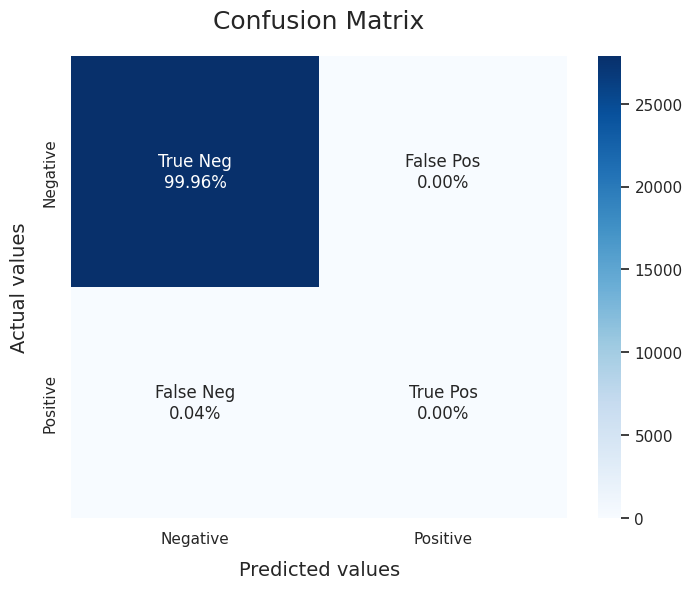



Classification Report

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27881
           2       0.00      0.00      0.00        12

    accuracy                           1.00     27893
   macro avg       0.50      0.50      0.50     27893
weighted avg       1.00      1.00      1.00     27893


ROC AUC Score: 0.5


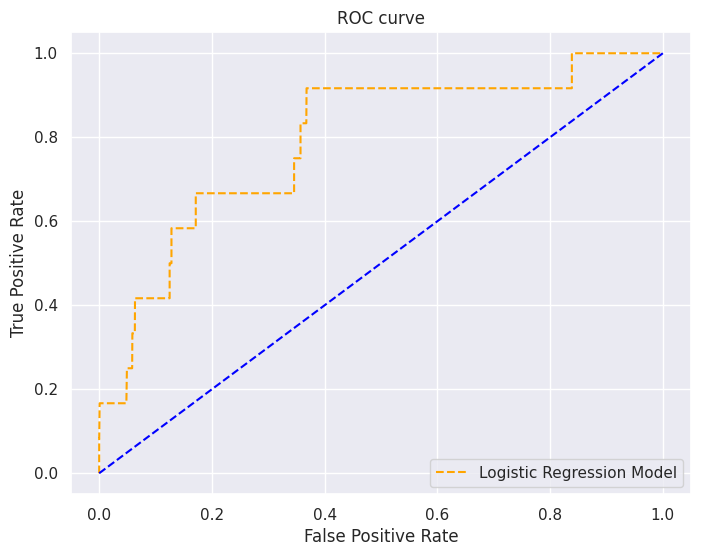

In [204]:
# Evaluating the model

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


# Predicting the labels for train data
y_pred = best_lr_model.predict(X_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)


# Converting labels to binary format
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Get probabilities
y_pred_proba = best_lr_model.predict_proba(X_test)

# Get False Positive rate, True Positive rate, and the threshold
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba[:, 1])

# ROC curve for a random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test_bin))]
p_fpr, p_tpr, _ = roc_curve(y_test_bin, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--', color='orange', label='Logistic Regression Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# Naive Bayes

1. Gaussian Naive Bayes -> if our dataset is in normal/gaussian distribution format
2. Multinomial Naive Bayes - text classification(NLP)

In [205]:
1+2+30+50

83

In [206]:
# Multinomial Naive Bayes without SMOTE, RUS , ROS

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

mnb = MultinomialNB()

mnb.fit(X_train, y_train)

y_pred = mnb.predict(X_test)

print(classification_report(y_test, y_pred ))



              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27881
           2       0.00      0.00      0.00        12

    accuracy                           1.00     27893
   macro avg       0.50      0.50      0.50     27893
weighted avg       1.00      1.00      1.00     27893



In [207]:
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [208]:
# Multinomial Naive Bayes with SMOTE

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=50)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

mnb = MultinomialNB()

mnb.fit(X_train_resampled, y_train_resampled)

y_pred = mnb.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       1.00      0.63      0.77     27881
           2       0.00      0.67      0.00        12

    accuracy                           0.63     27893
   macro avg       0.50      0.65      0.39     27893
weighted avg       1.00      0.63      0.77     27893



In [209]:
y_train.value_counts()

Target
1         65062
2            21
Name: count, dtype: int64

In [210]:
y_train_resampled.value_counts()

Target
1         65062
2         65062
Name: count, dtype: int64

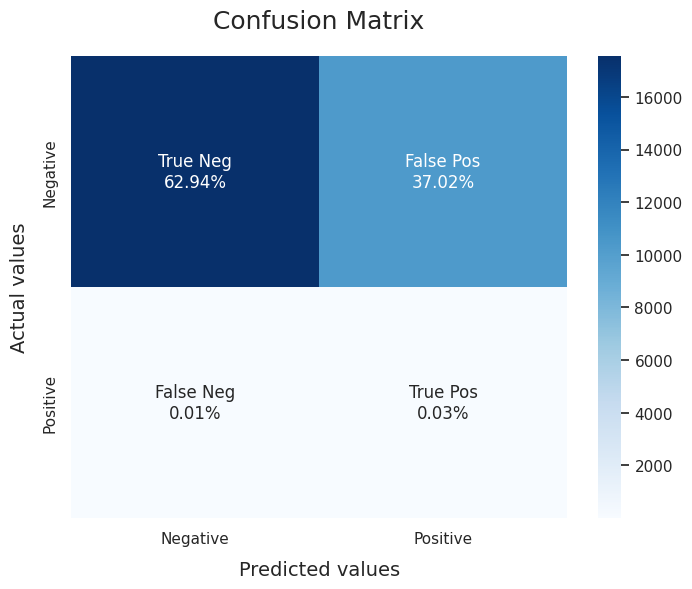



Classification Report

              precision    recall  f1-score   support

           1       1.00      0.63      0.77     27881
           2       0.00      0.67      0.00        12

    accuracy                           0.63     27893
   macro avg       0.50      0.65      0.39     27893
weighted avg       1.00      0.63      0.77     27893


ROC AUC Score: 0.6481713950958239


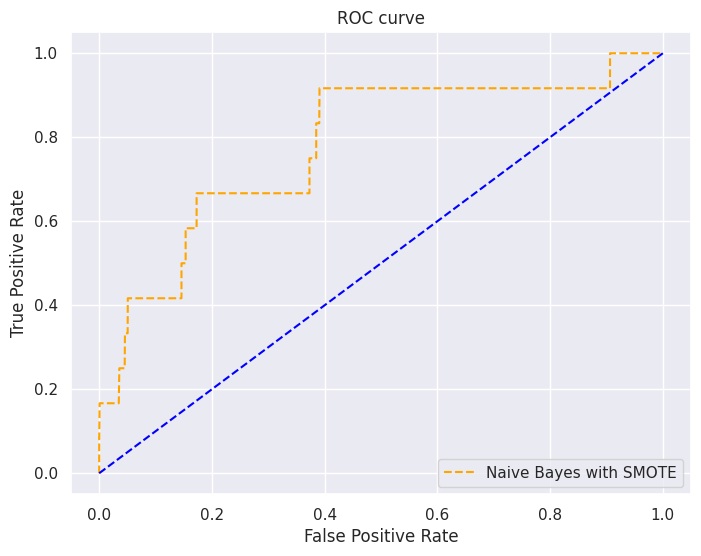

In [211]:
# Evaluating the model after applying RUS

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


# Predicting the labels for train data
y_pred = mnb.predict(X_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)


# Get probabilities
y_pred_proba = mnb.predict_proba(X_test)

# Get False Positive rate, True Positive rate, and the threshold
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba[:, 1])

# ROC curve for a random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test_bin))]
p_fpr, p_tpr, _ = roc_curve(y_test_bin, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--', color='orange', label='Naive Bayes with SMOTE')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [212]:
# Multinomial Naive Bayes with Random Under Sampling (RUS)

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=50)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

mnb = MultinomialNB()

mnb.fit(X_train_resampled, y_train_resampled)

y_pred = mnb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.59      0.74     27881
           2       0.00      0.92      0.00        12

    accuracy                           0.59     27893
   macro avg       0.50      0.75      0.37     27893
weighted avg       1.00      0.59      0.74     27893



In [213]:
X_train.head()

no_of_days_active         R    F         M  avg_time_between_purchase  \
41919           0.003379  0.333333  1.0  1.000000                   0.016667   
16728           0.002872  0.666667  0.0  0.666667                   0.000000   
20341           0.003548  0.000000  0.0  0.000000                   0.000000   
61234           0.018922  0.666667  0.0  0.000000                   0.000000   
87762           0.007603  1.000000  0.0  0.666667                   0.066667   

       Loyalty_Level_Bronze  Loyalty_Level_Silver  Loyalty_Level_Gold  \
41919                 False                 False               False   
16728                 False                 False                True   
20341                  True                 False               False   
61234                 False                  True               False   
87762                 False                 False               False   

       Loyalty_Level_Platinum  
41919                    True  
16728                   False  
20341                   False  
61234                   False  
87762                    True

In [214]:
X_train.shape

(65083, 9)

In [215]:
y_train.value_counts()

Target
1         65062
2            21
Name: count, dtype: int64

In [216]:
y_train_resampled.value_counts()

Target
1         21
2         21
Name: count, dtype: int64

In [217]:
X_train_resampled.head()

no_of_days_active         R    F         M  avg_time_between_purchase  \
73125           0.002365  1.000000  1.0  1.000000                   0.116667   
45366           0.001858  0.000000  0.0  0.666667                   0.000000   
81818           0.056597  0.333333  1.0  1.000000                   0.016667   
44686           0.006589  0.000000  1.0  0.000000                   0.116667   
29131           0.004055  0.666667  0.0  0.333333                   0.133333   

       Loyalty_Level_Bronze  Loyalty_Level_Silver  Loyalty_Level_Gold  \
73125                 False                 False               False   
45366                 False                  True               False   
81818                 False                 False               False   
44686                 False                  True               False   
29131                 False                 False                True   

       Loyalty_Level_Platinum  
73125                    True  
45366                   False  
81818                    True  
44686                   False  
29131                   False

In [218]:
X_train_resampled.shape

(42, 9)

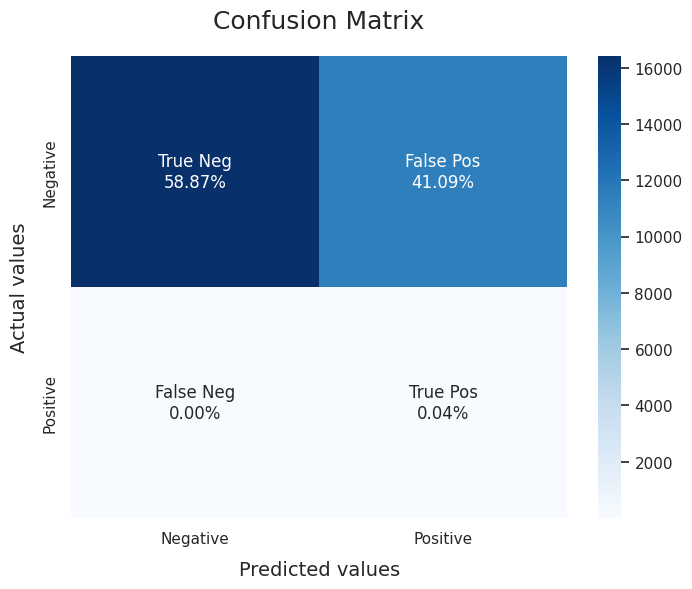



Classification Report

              precision    recall  f1-score   support

           1       1.00      0.59      0.74     27881
           2       0.00      0.92      0.00        12

    accuracy                           0.59     27893
   macro avg       0.50      0.75      0.37     27893
weighted avg       1.00      0.59      0.74     27893


ROC AUC Score: 0.7528170319094245


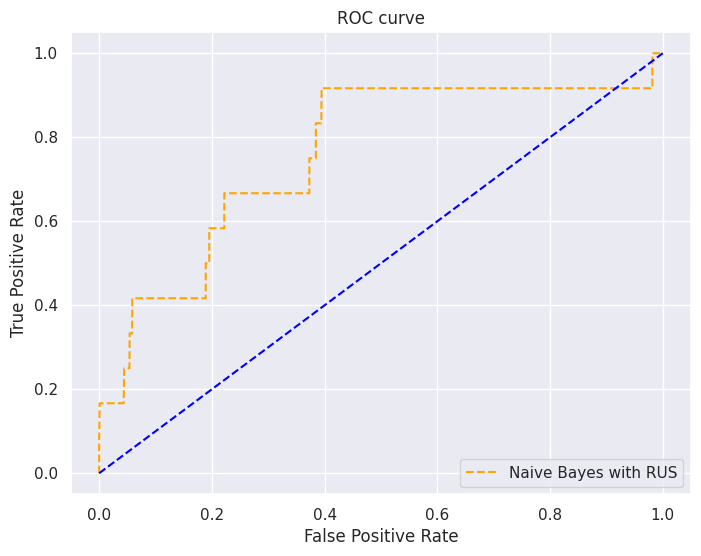

In [219]:
# Evaluating the model after applying RUS

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


# Predicting the labels for train data
y_pred = mnb.predict(X_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)


# # Converting labels to binary format
# lb = LabelBinarizer()
# y_test_bin = mnb.fit_transform(y_test)

# Get probabilities
y_pred_proba = mnb.predict_proba(X_test)

# Get False Positive rate, True Positive rate, and the threshold
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba[:, 1])

# ROC curve for a random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test_bin))]
p_fpr, p_tpr, _ = roc_curve(y_test_bin, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--', color='orange', label='Naive Bayes with RUS')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [220]:
# Multinomial Naive Bayes with Random Over Sampling (ROS)

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=50)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

mnb = MultinomialNB()

mnb.fit(X_train_resampled, y_train_resampled)

y_pred = mnb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.63      0.77     27881
           2       0.00      0.67      0.00        12

    accuracy                           0.63     27893
   macro avg       0.50      0.65      0.39     27893
weighted avg       1.00      0.63      0.77     27893



In [221]:
X_train.shape

(65083, 9)

In [222]:
y_train.value_counts()

Target
1         65062
2            21
Name: count, dtype: int64

In [223]:
X_train_resampled.shape

(130124, 9)

In [224]:
y_train_resampled.value_counts()

Target
1         65062
2         65062
Name: count, dtype: int64

In [225]:
y_test.value_counts()

Target
1         27881
2            12
Name: count, dtype: int64

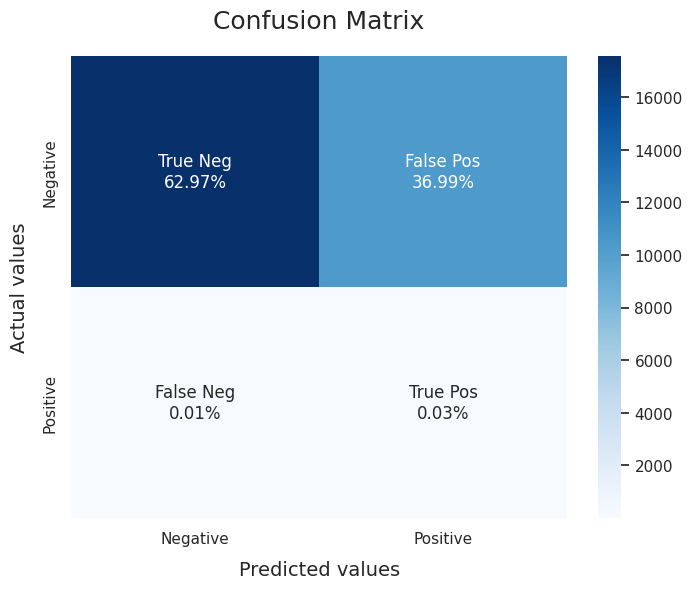



Classification Report

              precision    recall  f1-score   support

           1       1.00      0.63      0.77     27881
           2       0.00      0.67      0.00        12

    accuracy                           0.63     27893
   macro avg       0.50      0.65      0.39     27893
weighted avg       1.00      0.63      0.77     27893


ROC AUC Score: 0.6482969286132731


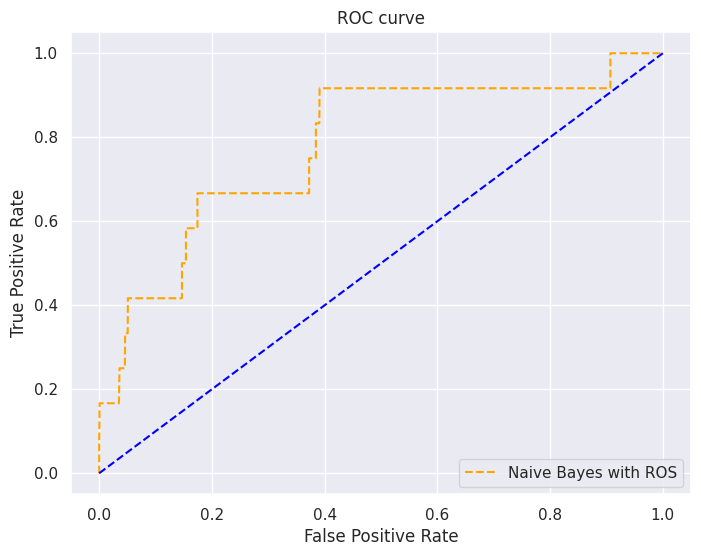

In [226]:
# Evaluating the model

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


# Predicting the labels for train data
y_pred = mnb.predict(X_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)


# Get probabilities
y_pred_proba = mnb.predict_proba(X_test)

# Get False Positive rate, True Positive rate, and the threshold
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba[:, 1])

# ROC curve for a random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test_bin))]
p_fpr, p_tpr, _ = roc_curve(y_test_bin, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--', color='orange', label='Naive Bayes with ROS')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

### Class Balancing Techniques
Random Under sampling(RUS)
Random Over Sampling(ROS)
SMOTE(SYnthetic Minority Oversampling Technique)

Class Weight (we dont modify the data, we will just specify weightage to each class like more weightage to minority class and less weightage to majority class)

# Random Forest

In [227]:
# Random forest without classweight

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=50)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27881
           2       0.33      0.08      0.13        12

    accuracy                           1.00     27893
   macro avg       0.67      0.54      0.57     27893
weighted avg       1.00      1.00      1.00     27893



In [228]:
# Random forest with classweight

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight='balanced', random_state=50)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print('Random Forest Classification Report:')
print(classification_report(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27881
           2       0.02      0.17      0.03        12

    accuracy                           1.00     27893
   macro avg       0.51      0.58      0.51     27893
weighted avg       1.00      1.00      1.00     27893



In [229]:
# Random forest with SMOTE

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=50)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(random_state=50)

rf_model.fit(X_train_resampled, y_train_resampled)

y_pred = rf_model.predict(X_test)

print('Random Forest Classification Report:')

print(classification_report(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27881
           2       0.03      0.08      0.04        12

    accuracy                           1.00     27893
   macro avg       0.51      0.54      0.52     27893
weighted avg       1.00      1.00      1.00     27893



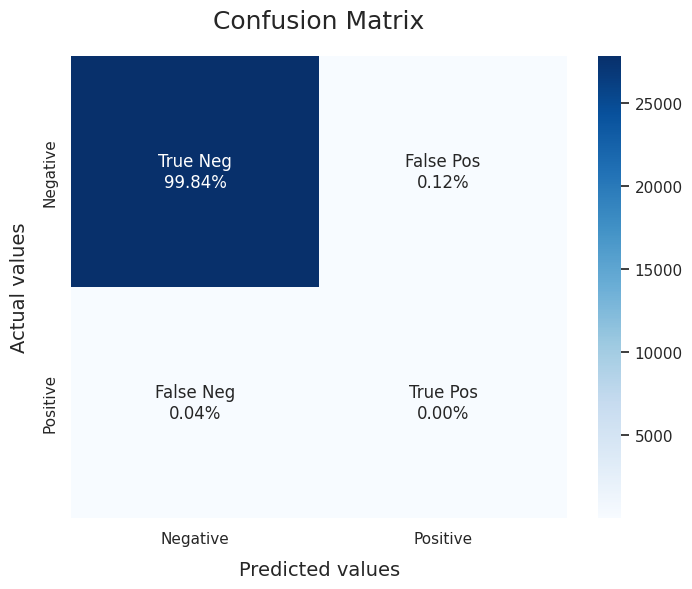



Classification Report

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27881
           2       0.03      0.08      0.04        12

    accuracy                           1.00     27893
   macro avg       0.51      0.54      0.52     27893
weighted avg       1.00      1.00      1.00     27893


ROC AUC Score: 0.5410569324390565


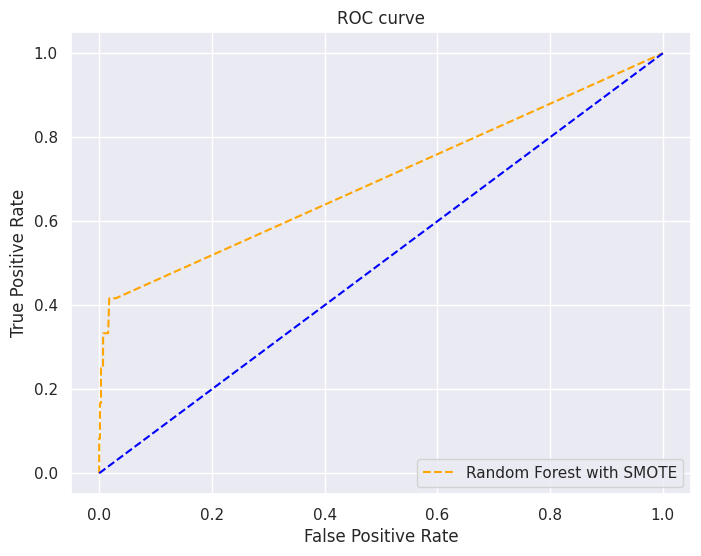

In [230]:
# Evaluating the model after applying SMOTE

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


# Predicting the labels for train data
y_pred = rf_model.predict(X_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)


# # Converting labels to binary format
# lb = LabelBinarizer()
# y_test_bin = mnb.fit_transform(y_test)

# Get probabilities
y_pred_proba = rf_model.predict_proba(X_test)

# Get False Positive rate, True Positive rate, and the threshold
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba[:, 1])

# ROC curve for a random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test_bin))]
p_fpr, p_tpr, _ = roc_curve(y_test_bin, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--', color='orange', label='Random Forest with SMOTE')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [231]:
# Random forest with Random Under Sampling (RUS)

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=50)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(random_state=50)

rf_model.fit(X_train_resampled, y_train_resampled)

y_pred = rf_model.predict(X_test)

print('Random Forest Classification Report:')

print(classification_report(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.72      0.84     27881
           2       0.00      0.92      0.00        12

    accuracy                           0.72     27893
   macro avg       0.50      0.82      0.42     27893
weighted avg       1.00      0.72      0.84     27893



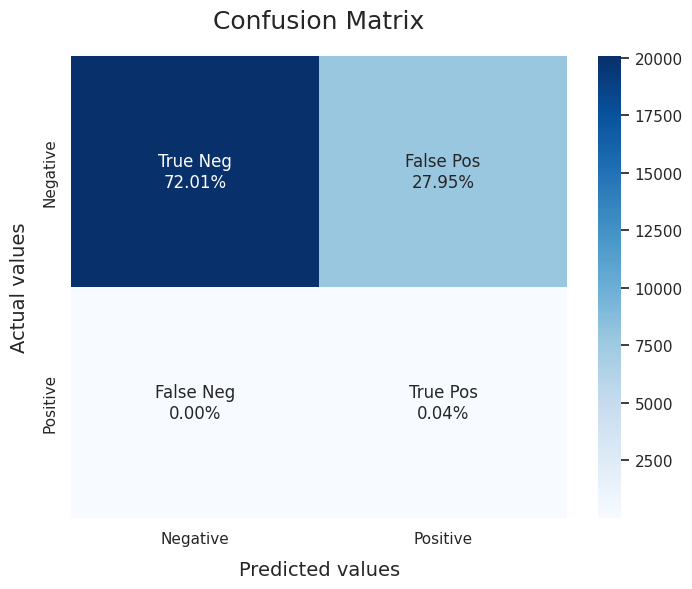



Classification Report

              precision    recall  f1-score   support

           1       1.00      0.72      0.84     27881
           2       0.00      0.92      0.00        12

    accuracy                           0.72     27893
   macro avg       0.50      0.82      0.42     27893
weighted avg       1.00      0.72      0.84     27893


ROC AUC Score: 0.818542794973877


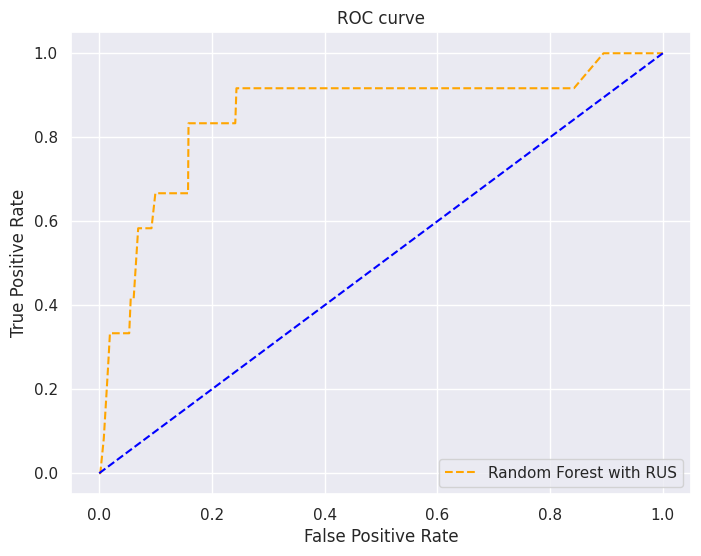

In [232]:
# Evaluating the model after applying RUS

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


# Predicting the labels for train data
y_pred = rf_model.predict(X_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)


# # Converting labels to binary format
# lb = LabelBinarizer()
# y_test_bin = mnb.fit_transform(y_test)

# Get probabilities
y_pred_proba = rf_model.predict_proba(X_test)

# Get False Positive rate, True Positive rate, and the threshold
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba[:, 1])

# ROC curve for a random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test_bin))]
p_fpr, p_tpr, _ = roc_curve(y_test_bin, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--', color='orange', label='Random Forest with RUS')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [233]:
# Random forest  with Random Over Sampling (ROS)

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=50)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(random_state=50)

rf_model.fit(X_train_resampled, y_train_resampled)

y_pred = rf_model.predict(X_test)

print('Random Forest Classification Report:')

print(classification_report(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27881
           2       0.02      0.17      0.03        12

    accuracy                           1.00     27893
   macro avg       0.51      0.58      0.51     27893
weighted avg       1.00      1.00      1.00     27893



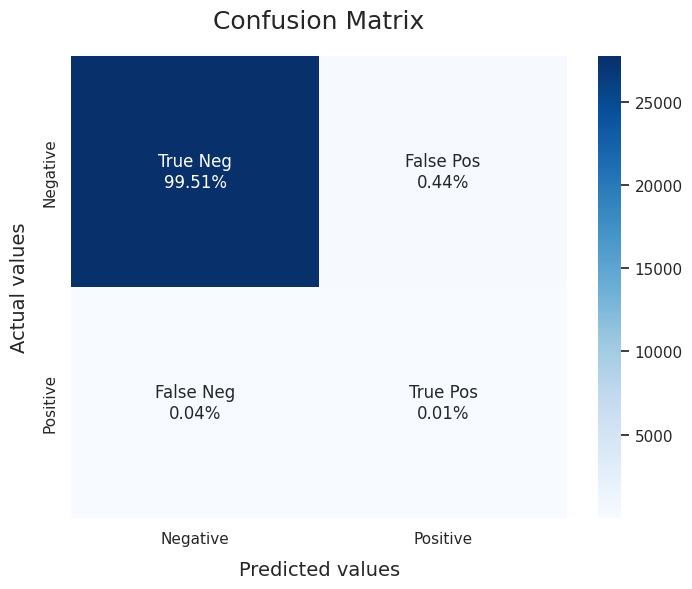



Classification Report

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27881
           2       0.02      0.17      0.03        12

    accuracy                           1.00     27893
   macro avg       0.51      0.58      0.51     27893
weighted avg       1.00      1.00      1.00     27893


ROC AUC Score: 0.5811095967385197


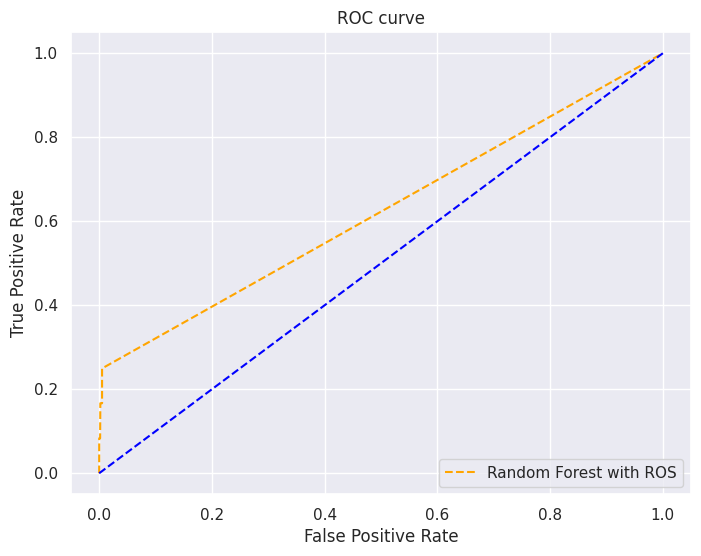

In [234]:
# Evaluating the model after applying ROS

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


# Predicting the labels for train data
y_pred = rf_model.predict(X_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)


# # Converting labels to binary format
# lb = LabelBinarizer()
# y_test_bin = mnb.fit_transform(y_test)

# Get probabilities
y_pred_proba = rf_model.predict_proba(X_test)

# Get False Positive rate, True Positive rate, and the threshold
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba[:, 1])

# ROC curve for a random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test_bin))]
p_fpr, p_tpr, _ = roc_curve(y_test_bin, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--', color='orange', label='Random Forest with ROS')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

### Bagging - Creating a model using multiple machine learning models
#### eg: RandomForest( here we use multiple decision trees)
##### In Regression case- We take avaerage of the model outputs
##### In Classfification - We take majority(mode) output of the models
### Boosting -  We boost the capacity of a model through multiple iterations
#### eg : XGBoost, LightGBM, CatBoost



# XGBoost

In [235]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [236]:
y_train.head()

Target
41919       1
16728       1
20341       1
61234       1
87762       1

In [237]:
# Changing target label values from [1,2] to [0,1] fro xgboost

y_train = y_train-1
y_test = y_test -1

y_train.head()

Target
41919       0
16728       0
20341       0
61234       0
87762       0

In [238]:
# Random forest without classweight

from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=50)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print('XGBoost Classification Report:')
print(classification_report(y_test, y_pred))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27881
           1       0.50      0.08      0.14        12

    accuracy                           1.00     27893
   macro avg       0.75      0.54      0.57     27893
weighted avg       1.00      1.00      1.00     27893



In [239]:
# Hyperparametertuning the XGBoost model

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from tqdm import tqdm
import joblib
# from collections import Counter

# Creatining model isntance
xgb_clf = XGBClassifier()

# Estimating scale_pos_weight value
# estimate = counter[0]/counter[1]

# Parameter grid
param = {'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
        'max_depth':[3,4,5,6,7,8,9,10,11,12],
        'min_child_weight':[0.1, 0.5,1,2,4,6,8,10],
        'subsample': [0.5, 0.7,0.8,0.9],
        'colsample_bytree':[0.5,0.7,0.8,0.9],
        'n_estimators':[100,200,300,500],
        'reg_alpha':[0,0.1,0.5,1,4,6,8,10],
        'reg_lambda': [0,0.1,0.5,1,4,6,8,10]}

# Creating folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

model =  RandomizedSearchCV(estimator = xgb_clf, param_distributions =param, scoring='f1', n_iter=30, cv=folds, verbose=2, random_state=50)

model.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END colsample_bytree=0.8, learning_rate=0.4, max_depth=3, min_child_weight=6, n_estimators=200, reg_alpha=10, reg_lambda=0, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.4, max_depth=3, min_child_weight=6, n_estimators=200, reg_alpha=10, reg_lambda=0, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.4, max_depth=3, min_child_weight=6, n_estimators=200, reg_alpha=10, reg_lambda=0, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.4, max_depth=3, min_child_weight=6, n_estimators=200, reg_alpha=10, reg_lambda=0, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.4, max_depth=3, min_child_weight=6, n_estimators=200, reg_alpha=10, reg_lambda=0, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.2, max_depth=12, min_child_weight=0.5, n_estimators=500, reg_alpha=4, reg_la

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.8,
                                                             0.9],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      11, 12],
                                        'min_child_weight': [0.1, 0.5, 1, 2, 4,
                                                             6, 8, 10],
                                        'n_estimators': [100, 200, 300, 500],
                                        'reg_alpha': [0, 0.1, 0.5, 1, 4, 6, 8,
                                                      10],
                                        'reg_lambda': [0, 0.1, 0.5, 1, 4, 6, 8,
                                                       10],
                                        'subsample': [0.5, 0.7, 0.8, 0.9]},
                   random_state=50, scoring='f1', verbose=2)

In [240]:
# Printing best hyperparameters

print('Best F1 Score:', model.best_score_)
print('Best Hyperparamaters:', model.best_params_)

Best F1 Score: 0.1142857142857143
Best Hyperparamaters: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 11, 'learning_rate': 0.4, 'colsample_bytree': 0.8}


In [241]:
# Building the model again with best hyperparameters

# Creatining model isntance
xgb_clf_tuned = XGBClassifier(subsample= 0.7, reg_lambda= 1, reg_alpha= 1, n_estimators= 500, min_child_weight= 1, max_depth= 3, learning_rate= 0.1, colsample_bytree= 0.8)


xgb_clf_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

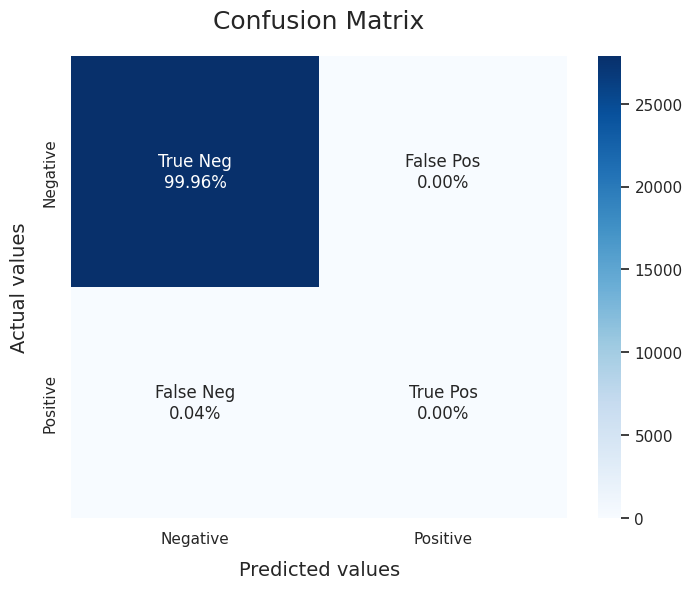



Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27881
           1       0.00      0.00      0.00        12

    accuracy                           1.00     27893
   macro avg       0.50      0.50      0.50     27893
weighted avg       1.00      1.00      1.00     27893


ROC AUC Score: 0.5


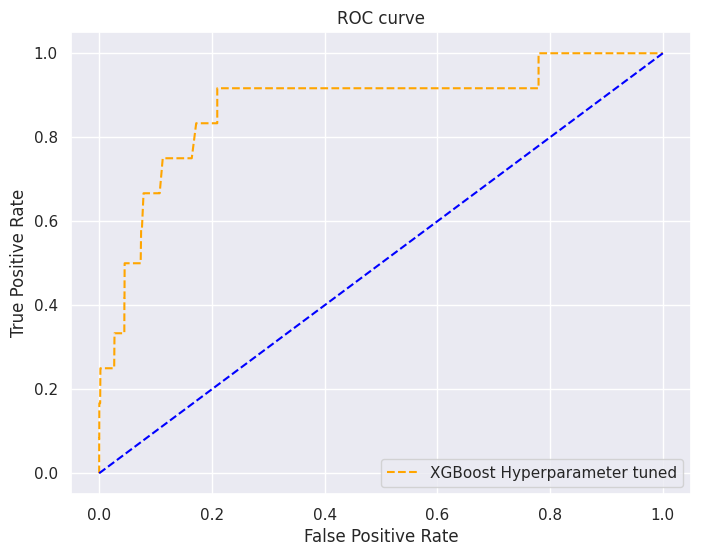

In [242]:
# Evaluating the model after applying SMOTE

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


# Predicting the labels for train data
y_pred = xgb_clf_tuned.predict(X_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)


# # Converting labels to binary format
# lb = LabelBinarizer()
# y_test_bin = mnb.fit_transform(y_test)

# Get probabilities
y_pred_proba = xgb_clf_tuned.predict_proba(X_test)

# Get False Positive rate, True Positive rate, and the threshold
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba[:, 1])

# ROC curve for a random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test_bin))]
p_fpr, p_tpr, _ = roc_curve(y_test_bin, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--', color='orange', label='XGBoost Hyperparameter tuned')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [243]:
# Random forest with Random Under Sampling (RUS)

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=50)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(subsample= 0.7, reg_lambda= 1, reg_alpha= 1, n_estimators= 500, min_child_weight= 1, max_depth= 3, learning_rate= 0.1, colsample_bytree= 0.8, random_state=50)

xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred = xgb_model.predict(X_test)

print('XGBoost Classification Report:')

print(classification_report(y_test, y_pred))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     27881
           1       0.00      0.92      0.00        12

    accuracy                           0.73     27893
   macro avg       0.50      0.82      0.42     27893
weighted avg       1.00      0.73      0.84     27893



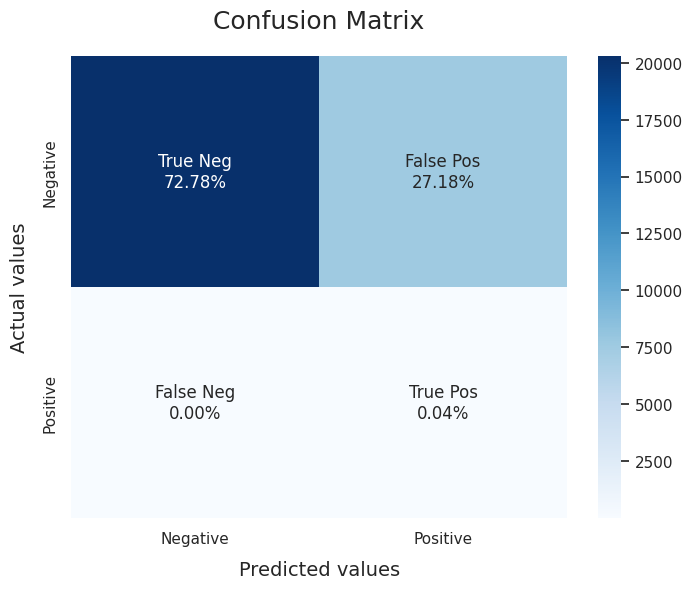



Classification Report

              precision    recall  f1-score   support

           0       1.00      0.73      0.84     27881
           1       0.00      0.92      0.00        12

    accuracy                           0.73     27893
   macro avg       0.50      0.82      0.42     27893
weighted avg       1.00      0.73      0.84     27893


ROC AUC Score: 0.8223984672955298


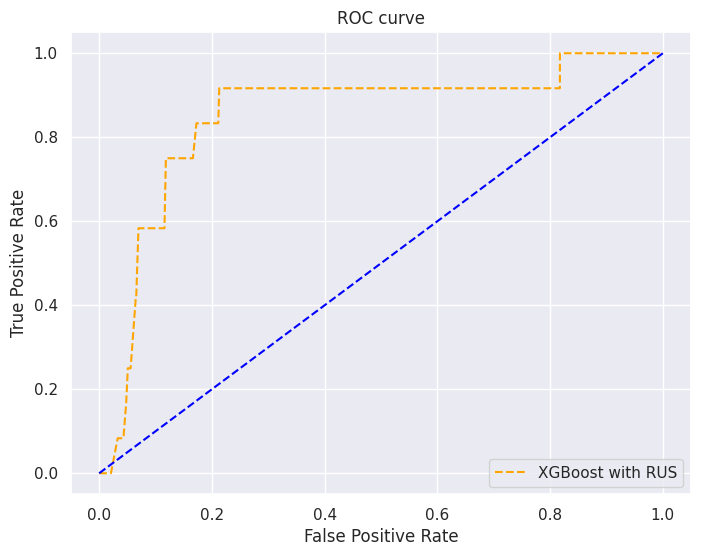

In [244]:
# Evaluating the model after applying RUS

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


# Predicting the labels for train data
y_pred = xgb_model.predict(X_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)


# # Converting labels to binary format
# lb = LabelBinarizer()
# y_test_bin = mnb.fit_transform(y_test)

# Get probabilities
y_pred_proba = xgb_model.predict_proba(X_test)

# Get False Positive rate, True Positive rate, and the threshold
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba[:, 1])

# ROC curve for a random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test_bin))]
p_fpr, p_tpr, _ = roc_curve(y_test_bin, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--', color='orange', label='XGBoost with RUS')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [245]:
# XGBoost  with Random Over Sampling (ROS)

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=50)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(subsample= 0.7, reg_lambda= 1, reg_alpha= 1, n_estimators= 500, min_child_weight= 1, max_depth= 3, learning_rate= 0.1, colsample_bytree= 0.8, random_state=50)

xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred = xgb_model.predict(X_test)

print('XGBoost Classification Report:')

print(classification_report(y_test, y_pred))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     27881
           1       0.02      0.25      0.03        12

    accuracy                           0.99     27893
   macro avg       0.51      0.62      0.51     27893
weighted avg       1.00      0.99      1.00     27893



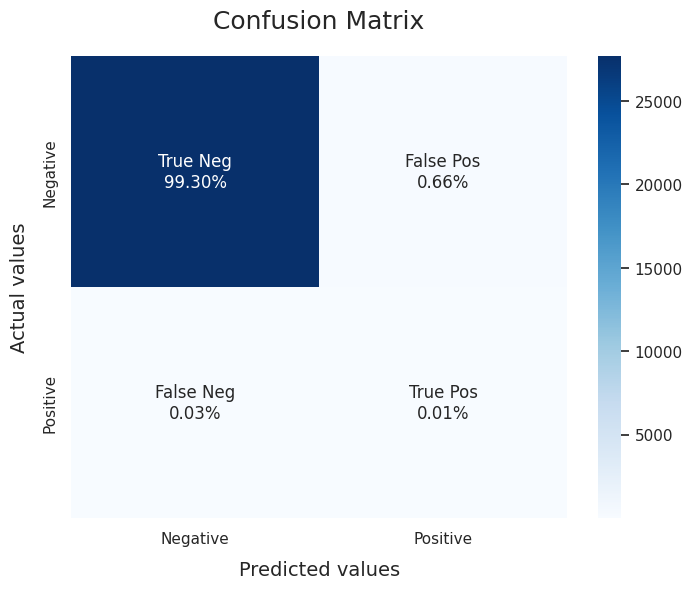



Classification Report

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     27881
           1       0.02      0.25      0.03        12

    accuracy                           0.99     27893
   macro avg       0.51      0.62      0.51     27893
weighted avg       1.00      0.99      1.00     27893


ROC AUC Score: 0.6217002618270506


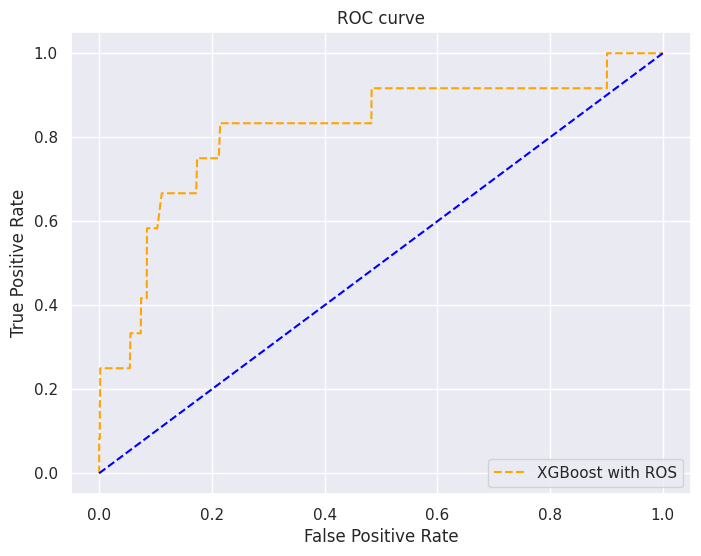

In [246]:
# Evaluating the model after applying ROS

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


# Predicting the labels for train data
y_pred = xgb_model.predict(X_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)


# # Converting labels to binary format
# lb = LabelBinarizer()
# y_test_bin = mnb.fit_transform(y_test)

# Get probabilities
y_pred_proba = xgb_model.predict_proba(X_test)

# Get False Positive rate, True Positive rate, and the threshold
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba[:, 1])

# ROC curve for a random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test_bin))]
p_fpr, p_tpr, _ = roc_curve(y_test_bin, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--', color='orange', label='XGBoost with ROS')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# LIGHTGBM

In [248]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [249]:
# LightGBM without hyperparamaeter tuning

import lightgbm as lgb

# Instantiating lightgbm model
lgb_model = lgb.LGBMClassifier()

# Model training
lgb_model.fit(X_train, y_train)

# Making predictions
y_pred = lgb_model.predict(X_test)

print('LightGBM Classification Report:')
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 21, number of negative: 65062
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 65083, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000323 -> initscore=-8.038574
[LightGBM] [Info] Start training from score -8.038574
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27881
           1       0.00      0.00      0.00        12

    accuracy                           1.00     27893
   macro avg       0.50      0.50      0.50     27893
weighted avg       1.00      1.00      1.00     27893



In [250]:
# Hyperparametertuning the LightGBM model

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from tqdm import tqdm
import joblib
# from collections import Counter

# Creatining model instance
lgb_model = lgb.LGBMClassifier()

# Estimating scale_pos_weight value
# estimate = counter[0]/counter[1]

# Parameter grid
param = {'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
        'max_depth':[3,4,5,6,7,8,9,10,11,12],
         'num_leaves': [30,50,80,100,200,400],
        'max_bin':[3,4,5,6,7,8,9,10,12,14,16],
        'colsample_bytree':[0.5,0.7,0.8,0.9],
        'n_estimators':[100,200,300,500],
         'bagging_fraction':[0.2,0.4,0.6,0.8,0.95],
         'bagging_freq':[0,1],
         'feature_fraction':[0.2,0.4,0.6,0.8,0.95],
        'lambda_l1':[0,0.1,0.5,1,4,6,8,10],
        'lambda_l2': [0,0.1,0.5,1,4,6,8,10]}

# Creating folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

model =  RandomizedSearchCV(estimator = lgb_model, param_distributions =param, scoring='f1', n_iter=30, cv=folds, verbose=2, random_state=50)

model.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=50, shuffle=True),
                   estimator=LGBMClassifier(), n_iter=30,
                   param_distributions={'bagging_fraction': [0.2, 0.4, 0.6, 0.8,
                                                             0.95],
                                        'bagging_freq': [0, 1],
                                        'colsample_bytree': [0.5, 0.7, 0.8,
                                                             0.9],
                                        'feature_fraction': [0.2, 0.4, 0.6, 0.8,
                                                             0.95],
                                        'lambda_l1': [0, 0.1, 0.5, 1, 4, 6, 8,
                                                      10],
                                        'lambda_l2': [0, 0.1, 0.5, 1, 4, 6, 8,
                                                      10],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4],
                                        'max_bin': [3, 4, 5, 6, 7, 8, 9, 10, 12,
                                                    14, 16],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      11, 12],
                                        'n_estimators': [100, 200, 300, 500],
                                        'num_leaves': [30, 50, 80, 100, 200,
                                                       400]},
                   random_state=50, scoring='f1', verbose=2)

In [251]:
# Printing best hyperparameters

print('Best F1 Score:', model.best_score_)
print('Best Hyperparamaters:', model.best_params_)

Best F1 Score: 0.0
Best Hyperparamaters: {'num_leaves': 200, 'n_estimators': 300, 'max_depth': 3, 'max_bin': 9, 'learning_rate': 0.1, 'lambda_l2': 8, 'lambda_l1': 0.1, 'feature_fraction': 0.4, 'colsample_bytree': 0.5, 'bagging_freq': 1, 'bagging_fraction': 0.2}


In [253]:
# Building the model again with best hyperparameters

# Creatining model isntance
lgb_clf_tuned = lgb.LGBMClassifier(num_leaves= 200, n_estimators= 300, max_depth= 3, max_bin= 9, learning_rate= 0.1, lambda_l2= 8, lambda_l1= 0.1, feature_fraction= 0.4, colsample_bytree= 0.5, bagging_freq= 1, bagging_fraction= 0.2)


lgb_clf_tuned.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[Lig

LGBMClassifier(bagging_fraction=0.2, bagging_freq=1, colsample_bytree=0.5,
               feature_fraction=0.4, lambda_l1=0.1, lambda_l2=8, max_bin=9,
               max_depth=3, n_estimators=300, num_leaves=200)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


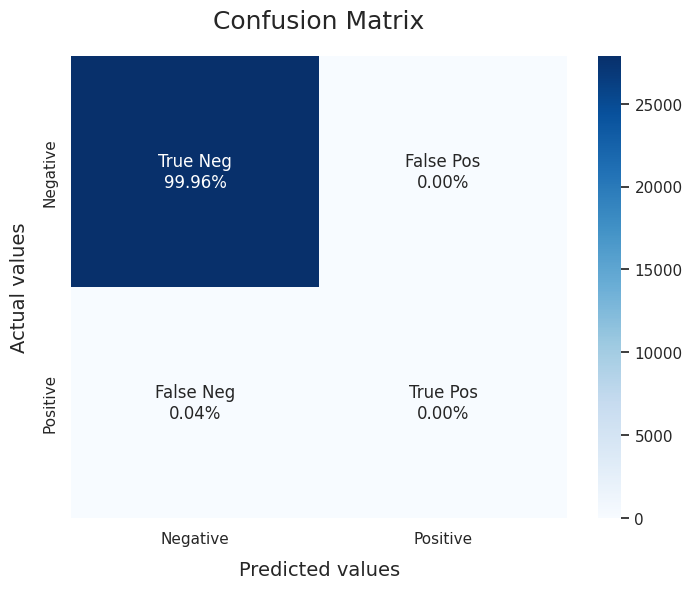



Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27881
           1       0.00      0.00      0.00        12

    accuracy                           1.00     27893
   macro avg       0.50      0.50      0.50     27893
weighted avg       1.00      1.00      1.00     27893


ROC AUC Score: 0.5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


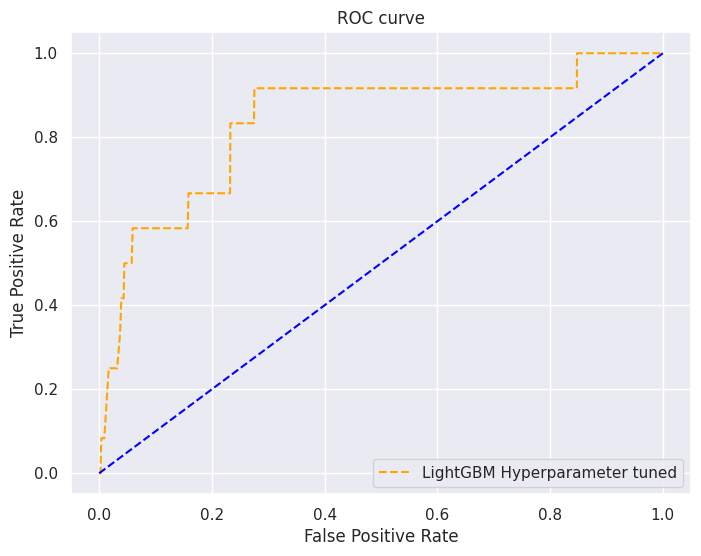

In [254]:
# Evaluating the model after applying SMOTE

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


# Predicting the labels for train data
y_pred = lgb_clf_tuned.predict(X_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)


# # Converting labels to binary format
# lb = LabelBinarizer()
# y_test_bin = mnb.fit_transform(y_test)

# Get probabilities
y_pred_proba = lgb_clf_tuned.predict_proba(X_test)

# Get False Positive rate, True Positive rate, and the threshold
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba[:, 1])

# ROC curve for a random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test_bin))]
p_fpr, p_tpr, _ = roc_curve(y_test_bin, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--', color='orange', label='LightGBM Hyperparameter tuned')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [255]:
# LightGBM with Random Under Sampling (RUS)

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=50)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

lgb_model = lgb.LGBMClassifier(num_leaves= 200, n_estimators= 300, max_depth= 3, max_bin= 9, learning_rate= 0.1, lambda_l2= 8, lambda_l1= 0.1, feature_fraction= 0.4, colsample_bytree= 0.5, bagging_freq= 1, bagging_fraction= 0.2)

lgb_model.fit(X_train_resampled, y_train_resampled)

y_pred = lgb_model.predict(X_test)

print('LightGBM Classification Report:')

print(classification_report(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[Lig

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


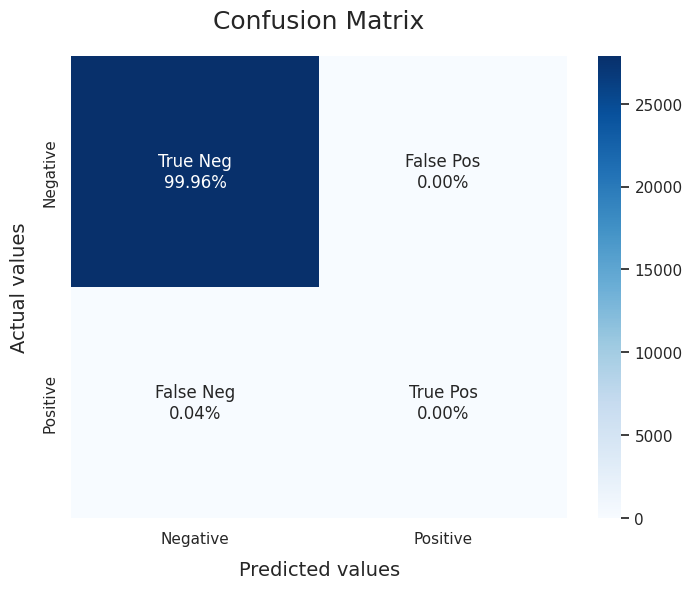



Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27881
           1       0.00      0.00      0.00        12

    accuracy                           1.00     27893
   macro avg       0.50      0.50      0.50     27893
weighted avg       1.00      1.00      1.00     27893


ROC AUC Score: 0.5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


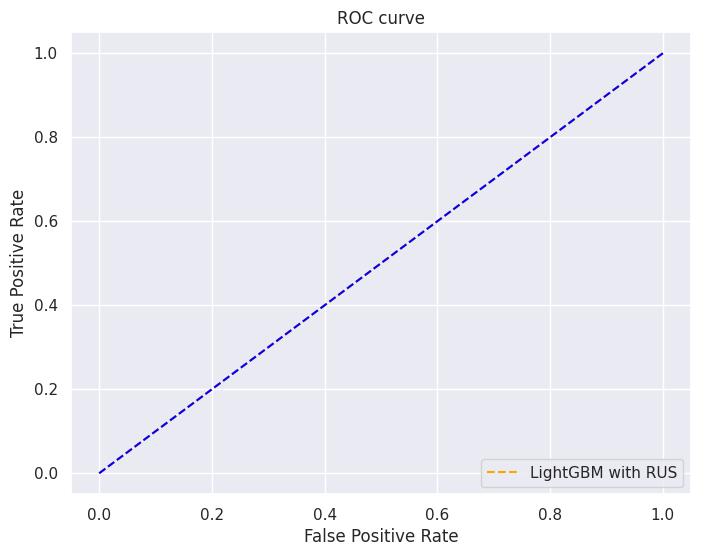

In [256]:
# Evaluating the model after applying RUS

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


# Predicting the labels for train data
y_pred = lgb_model.predict(X_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)


# # Converting labels to binary format
# lb = LabelBinarizer()
# y_test_bin = mnb.fit_transform(y_test)

# Get probabilities
y_pred_proba = lgb_model.predict_proba(X_test)

# Get False Positive rate, True Positive rate, and the threshold
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba[:, 1])

# ROC curve for a random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test_bin))]
p_fpr, p_tpr, _ = roc_curve(y_test_bin, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--', color='orange', label='LightGBM with RUS')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [257]:
# LightGBM with Random Over Sampling (ROS)

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=50)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

lgb_model = lgb.LGBMClassifier(num_leaves= 200, n_estimators= 300, max_depth= 3, max_bin= 9, learning_rate= 0.1, lambda_l2= 8, lambda_l1= 0.1, feature_fraction= 0.4, colsample_bytree= 0.5, bagging_freq= 1, bagging_fraction= 0.2)

lgb_model.fit(X_train_resampled, y_train_resampled)

y_pred = lgb_model.predict(X_test)

print('XGBoost Classification Report:')

print(classification_report(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[Lig

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


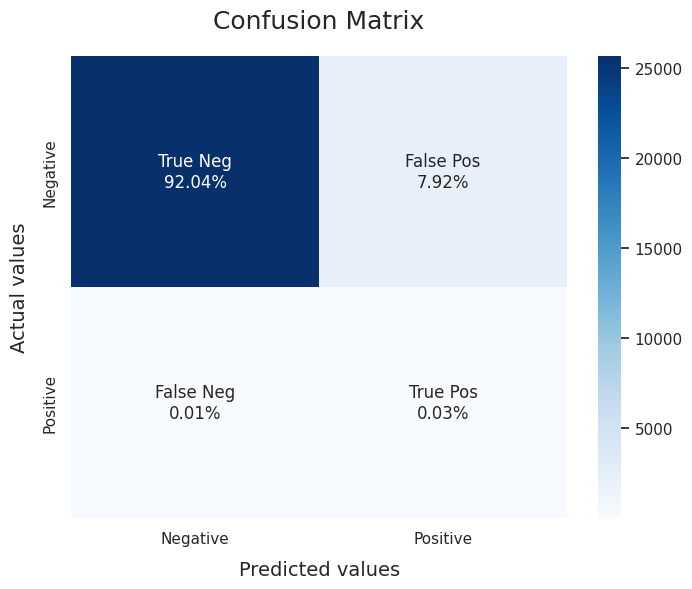



Classification Report

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     27881
           1       0.00      0.67      0.01        12

    accuracy                           0.92     27893
   macro avg       0.50      0.79      0.48     27893
weighted avg       1.00      0.92      0.96     27893


ROC AUC Score: 0.7937364752579414
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


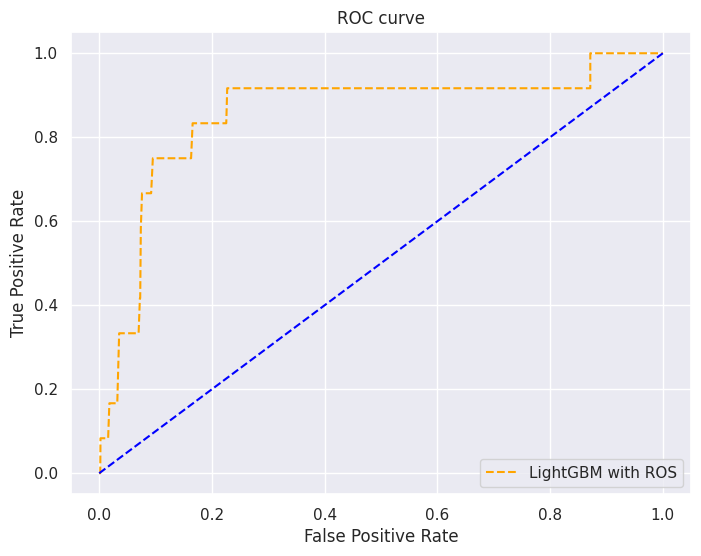

In [258]:
# Evaluating the model after applying ROS

# Importing necessary libraries to evaluate the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


# Predicting the labels for train data
y_pred = lgb_model.predict(X_test)


# Computing and plotting the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

plt.figure(figsize=(8, 6)) # Create a new figure for confusion matrix
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

# Printing the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

# Printing the Receiver operating characteristic Auc score
auc_score = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", auc_score)


# # Converting labels to binary format
# lb = LabelBinarizer()
# y_test_bin = mnb.fit_transform(y_test)

# Get probabilities
y_pred_proba = lgb_model.predict_proba(X_test)

# Get False Positive rate, True Positive rate, and the threshold
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba[:, 1])

# ROC curve for a random classifier tpr = fpr
random_probs = [0 for i in range(len(y_test_bin))]
p_fpr, p_tpr, _ = roc_curve(y_test_bin, random_probs, pos_label=1)

# Visualizing the ROC curve
plt.figure(figsize=(8, 6))  # Create a new figure for ROC
plt.plot(fpr, tpr, linestyle='--', color='orange', label='LightGBM with ROS')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# data_with_RFM.to_csv('/kaggle/working/final_customer_data_with_RFM_features.csv', index=False)

We have successfully grouped 62 segments based on individual R, F, M scores into 4 broad loyalty levels. Let's explore the characteristics of each loyalty levels.

**Customer Behaviour and potential targeting techniques for each Loyalty Level:**
1. **Platinum:** People in this group are more frequent buyers with average days since the last purchase is _ and average number of times they have transacted in the platform is about _ times in the last 1 month. Also, their average sales value is _ pounds.
These are your most loyal customers, who bought recently, most often, and are heavy spenders. Reward these customers so that they can become an early adopters for your future products and help to promote your brand.

2. **Gold:** This group has an average frequency of _ times and recency of _ days. This group is also high spenders with average sales of about _ pounds. 
 These are your recent customers with an average frequency and who spent a good amount. Offer membership or loyalty programs or recommend related products to upsell them and help them become your Platinum members.

3. **Silver:** People in this group have made a transaction on the platform about _ days ago. Their frequency and monetary values are _ times and _ pounds respectively.
These are your customers who purchased a decent number of times and spent good amounts, but haven’t purchased recently. Sending them personalized campaigns, offers, and product recommendations will help to reconnect with them.

4. **Bronze:** This is the dormant group with average days since their last purchase is _. They have transacted around _ times in the platform with average sales of _ pounds. 
These are customers who used to visit and purchase in your platform, but haven’t been visiting recently. Bring them back with relevant promotions, and run surveys to find out what went wrong and avoid losing them to a competitor.

# Conclusion

RFM is a data driven customer segmentation technique which allows to make informed decisions. It empowers marketers(ad creators) to quickly identify and segment users into homogeneous groups and target then with personalised marketing strategies. This improves user engagement and retention.

